In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import pylab as plt

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

# Chapter 8 - CONDITIONAL MANATEES

## End of Chapter Problems

### 8E1.

For each of the causal relationships below, name a hypothetical third variable that would lead
to an interaction effect.

(1) Bread dough rises because of yeast.

(2) Education leads to higher income.

(3) Gasoline makes a car go.

#### Answer 


1) Temperature as a third variable would lead to an interaction effect with the yeast. Presumably this is a fairly non-linear effect. Temperature would increase the impact of yeast on bread rising, but only up to a point. Beyond this point, temperature would start to kill the yeast.

2) Peer group at 17 years old. Presumably this interaction would go in both directions. Having a network of friends which is interested academic things would presumably bolster your academic performance, and having a good academic education is probably going to make it more likely that you would have this kind of peer group. Similarly, both of these things increase the likelihood that you would have better career outcomes, and due to the impacts of social capital on life outcomes, presumably education and your adult peer network interact in some way.

3) Strange one. Mundane variable about whether the ignition of the car has been used would interact with gasoline. In words, the interaction could be something like: The degree to which the car goes, given that it's got gasoline, depends on ignition use. Conversely, given the ignition has been used, the degree to which the car go will varies depending on gasoline being in the car.


### 8E2.

Which of the following explanations invokes an interaction?

(1) Caramelizing onions requires cooking over low heat and making sure the onions do not
dry out.

(2) A car will go faster when it has more cylinders or when it has a better fuel injector.

(3) Most people acquire their political beliefs from their parents, unless they get them instead
from their friends.

(4) Intelligent animal species tend to be either highly social or have manipulative appendages
(hands, tentacles, etc.).


#### Answer 


1) The degree of caramelizing depends on both factors interacting. If you just let the heat go up, and they dry out, then it won't caramelize

2) Each of these effects on the car is independent of the other, and there's no reason to think the synergy is going to be more than the sum of the parts

3) Interaction. Increasing the influence of friends will decrease the influence of parents and vice versa. It's plausible that this could even be modeled quite well by a symmetric interaction

4) Interaction. The degree to which having hands or tentacles predicts intelligence depends on the other. A species which has both or neither is unlikely to be intelligent, so the degree to which one of these variables predicts intelligence depends upon the other.

### 8E3.

For each of the explanations in 8E2, write a linear model that expresses the stated relationship.

#### Answer 
 Let's just stick with the basic linear symmetric interaction paradigm for this model.

1)  $\mu_i = \alpha + \beta_H H_i + \beta_D D_i + \beta_{HD}H_i D_i $

$\beta_{HD}$ will be positive to some degree. Why? Because $\beta_H$ will be negative, increasing the heat, should reduce the amount of impact that dryness will have, as extreme heat will make caramelization virtually impossible.

2)  $\mu_i = \alpha + \beta_C C_i + \beta_I I_i $

No interaction

3)  $\mu_i = \alpha + \beta_P P_i + \beta_F F_i + \beta_{PF}F_i P_i $

$\mu$ is the mean of the variable describing how close you are to your parents belief at the high end and friends at the low end.
Let's say that $\beta_P$ and $\beta_F$ are the effect size of exposure to parents and friends political beliefs respectively. For simplicity, assume large exposure swings you more towards the influencing group. So $\beta_P$ would be positive in this setup and $\beta_F$ negative.

$\beta_{FP}$ should be a negative interaction effect as you could imagine that increasing time spent with friends would moderate the impact that time spent would parents would have, and vice versa. Symmetry in the interaction in this toy model could represent the fact that friends and the parents are all in some sense competing for time with you.

(4) $Int = \alpha_{H \& T}$ Intelligence depends upon some interaction between having tentacles and hands.

### 8M1.

Recall the tulips example from the chapter. Suppose another set of treatments adjusted the
temperature in the greenhouse over two levels: cold and hot. The data in the chapter were collected
at the cold temperature. You find none of the plants grown under the hot temperature developed
any blooms at all, regardless of the water and shade levels. Can you explain this result in terms of
interactions between water, shade, and temperature?

#### Answer 
This behaviour could be explained by a 3-way interaction between all 3 separate pairwise interactions between the variables. Additional interactions between temperature and the other predictor variables which moderates their effect sizes could limit the degree to which plants grow in hot temperatures.

### 8M2.

Can you invent a regression equation that would make the bloom size zero, whenever the
temperature is hot?

In general the three way interaction would look something like this:

$\mu_i = \alpha + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_{12} x_1x_2 + \beta_{13} x_1x_3 + \beta_{23} x_12x_3 + \beta_{123} x_1x_2x_3$

Imagining using a temperature scale ranging from 0 to 1, 1 being a the hot end of the scale. When the temperature reaches 1, then the following equation would ensure that the mean bloom is zero when the temperature is zero.

$\mu_i = \alpha_2 - \alpha_2 T + (\beta \alpha_1  + \beta \beta_S S + \beta \beta_{W} W +\beta \beta_{SW}S W)  - T(\beta \alpha_1  + \beta \beta_S S + \beta \beta_{W} W +\beta \beta_{SW}S W) $



8.3 Too open ended for now

### 8M4.

Repeat the tulips analysis, but this time use priors that constrain the effect of water to be positive and the effect of shade to be negative. Use prior predictive simulation. What do these prior
assumptions mean for the interaction prior, if anything?

In [3]:
Tulip = pd.read_csv("./data/tulips.csv", delimiter=";")

#### Answer 

 So we use precisely the same model as model m8.5 in the text, except we will be using exponential random variables for the prior distributions to impose the constraints mentioned in the question. Why the exponential? I considered the log-normal, but this seemed far too weak over the ranges considered. Using an exponential with a range 0.25 seems far more sensible. In picking a $\lambda$ value for your prior distribution, you're simultaneously making a statement about the mean and the standard deviation and the range of values you expect it to take. We will use an exponential prior with $\lambda = 0.5$ as it is: constrained to be positive; relatively broad over the range of association strengths in the data; still expects that strength of association to be less than 1 around 80% of the time.

NB: To impose the negative constraint, I make the coefficient of the shade negative in the mean line itself

In [4]:
# make the unit transformations found in the book
Tulip["s_blooms"] = Tulip.blooms.values / np.max(Tulip.blooms.values)
Tulip["s_water"] = Tulip.water - np.mean(Tulip.water)
Tulip["s_shade"] = Tulip.shade - np.mean(Tulip.shade)

In [5]:
with pm.Model() as Bloom:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Exponential("beta", 2, shape=2)  # beta prior
    betaWS = pm.Normal(
        "betaWS",
        0,
        0.25,
    )  # interation prior
    sigma = pm.Exponential("sigma", 1)
    mu = (
        alpha
        + beta[0] * Tulip.s_water
        - beta[1] * Tulip.s_shade
        + betaWS * Tulip.s_shade.values * Tulip.s_water.values
    )
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Tulip.s_blooms)
    prior_sample = pm.sample_prior_predictive(samples=500)
    # first_sample = pm.sample(draws=500, chains=4, return_inferencedata=True, return_inferencedata=True)

In [6]:
Tulip.s_shade.drop_duplicates()

0   -1.0
1    0.0
2    1.0
Name: s_shade, dtype: float64

In [7]:
# Handy function for plotting the lines
def line(alpha, beta1, beta2, beta12):
    return lambda x1, x2: alpha + x1 * beta1 - x2 * beta2 + x1 * x2 * beta12

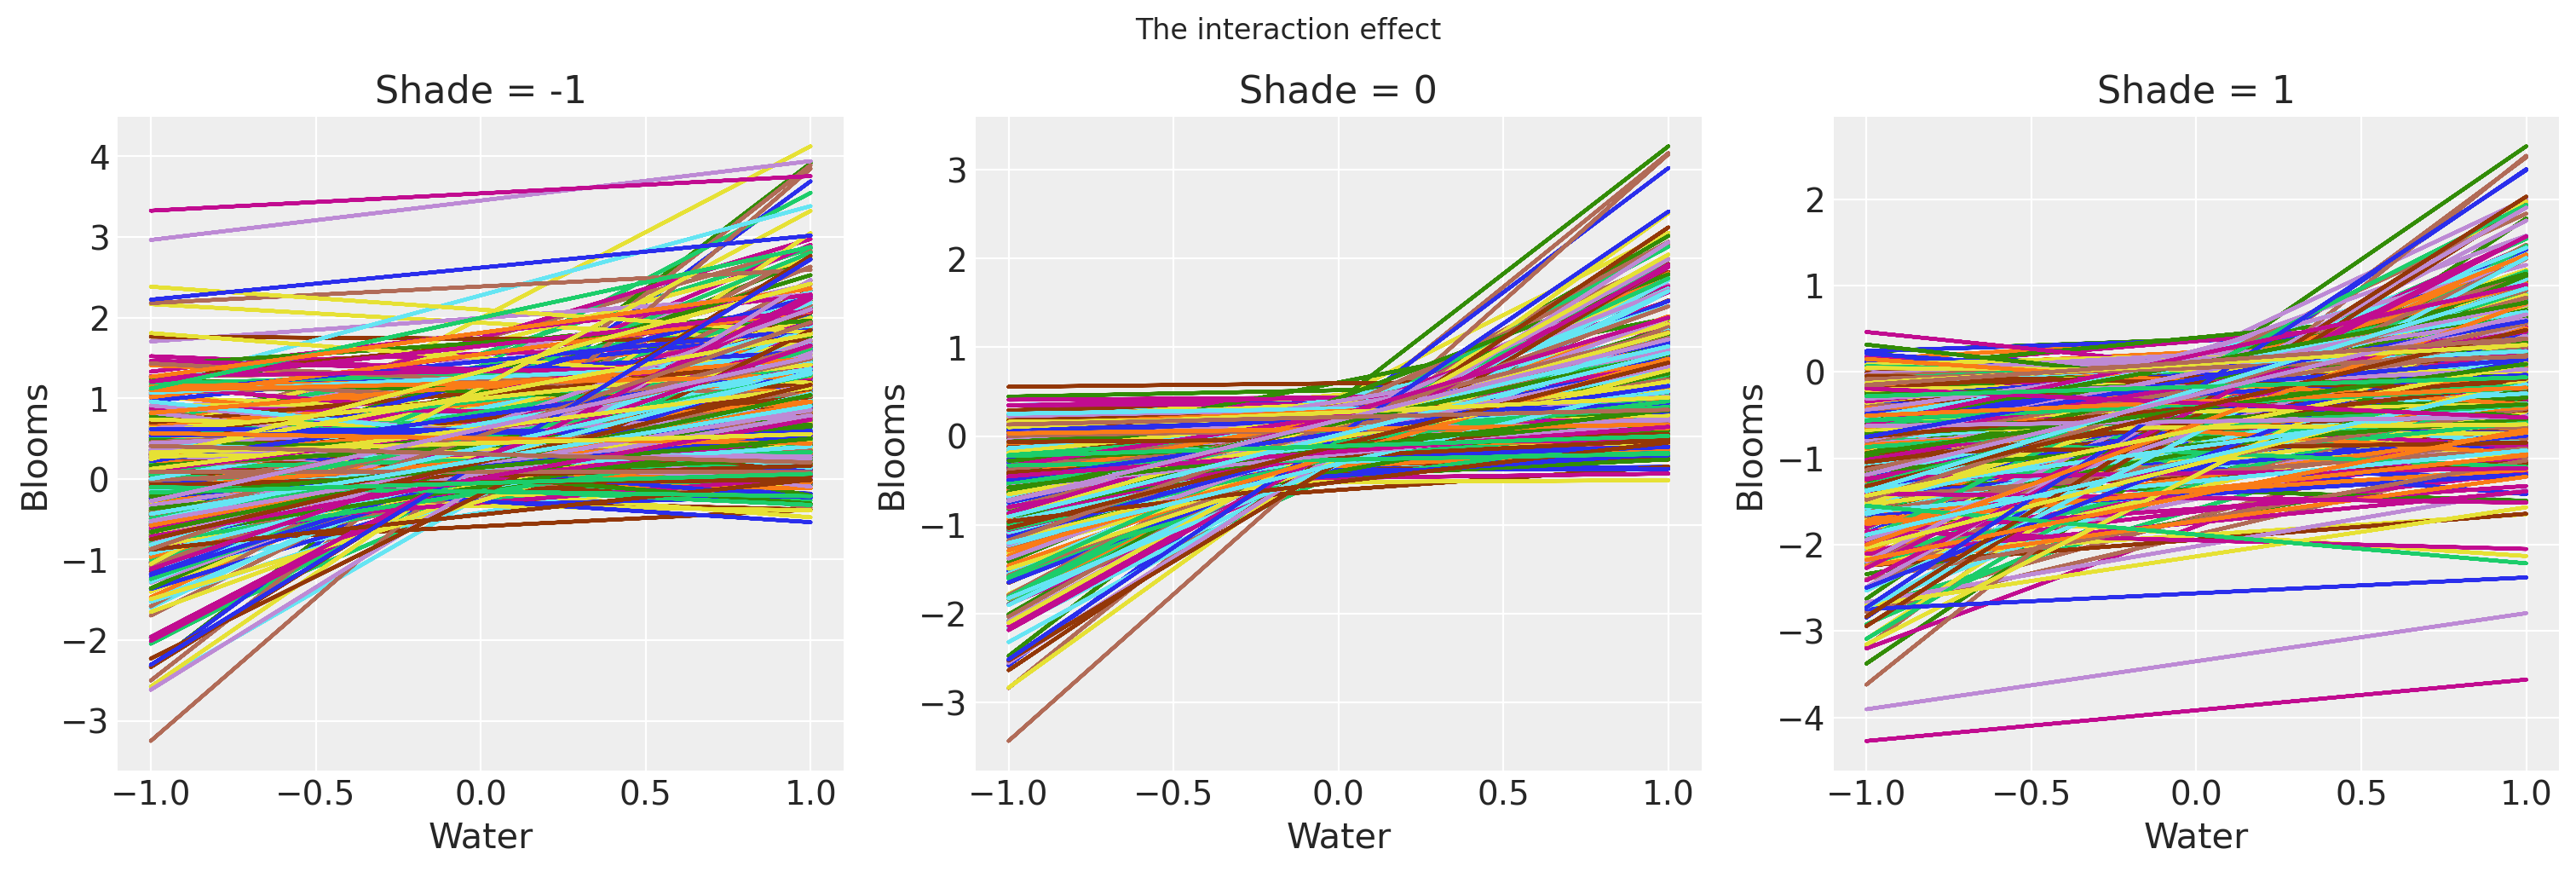

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("The interaction effect", fontsize=12)

for a, b1, b2, b12 in zip(
    prior_sample["alpha"],
    prior_sample["beta"][:, 0],
    prior_sample["beta"][:, 1],
    prior_sample["betaWS"],
):
    axs[0].plot(Tulip.s_water, line(a, b1, b2, b12)(Tulip.s_water, -np.ones(Tulip.shape[0])))
    axs[1].plot(Tulip.s_water, line(a, b1, b2, b12)(Tulip.s_water, 0))
    axs[2].plot(Tulip.s_water, line(a, b1, b2, b12)(Tulip.s_water, np.ones(Tulip.shape[0])))

axs[0].set_title("Shade = -1")
axs[1].set_title("Shade = 0")
axs[2].set_title("Shade = 1")

axs[0].set_xlabel("Water")
axs[1].set_xlabel("Water")
axs[2].set_xlabel("Water")

axs[0].set_ylabel("Blooms")
axs[1].set_ylabel("Blooms")
axs[2].set_ylabel("Blooms");

It's hard to unravel how impactful the interaction is on the prior as the lines are so scattered. However, it can be seen that when shade is low, that the probability of getting a lot of blooms i possible with a lot of water, reaching up the value of 4 when water = 1. When shade is high, this never happens. Moreover, when shade is high, and water is low very low values of blooms are now possible. The priors now prohibit negative relationships between water and blooms and that is reflected in the priors.

The prior is broadly symmetric. This changes imposed shouldn't mean anything for the interaction prior. Firstly, I didn't change a thing about the model that would impact this explicitly. If you were to think harder about this then would it really change anything? I don't think so

### 8H1.

Return to the data(tulips) example in the chapter. Now include the bed variable as a predictor in the interaction model. Don’t interact bed with the other predictors; just include it as a main
effect. Note that bed is categorical. So to use it properly, you will need to either construct dummy
variables or rather an index variable, as explained in Chapter 5.


#### Answer 

In [9]:
# map the bed categories to an index
ind = Tulip.bed.astype("category").cat.codes

In [10]:
with pm.Model() as Categorical_Bloom:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("betaWS", 0, 0.25, shape=(3, 3))  # beta priors
    sigma = pm.Exponential("sigma", 1)
    mu = (
        alpha
        + beta[0, ind] * Tulip.s_water
        + beta[1, ind] * Tulip.s_shade
        + beta[2, ind] * Tulip.s_shade.values * Tulip.s_water.values
    )
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Tulip.s_blooms)
    # prior_sample = pm.sample_prior_predictive(samples=500)
    Cat_bloom_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betaWS, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


In [11]:
az.summary(Cat_bloom_sample)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.350,0.028,0.306,0.392,0.001,0.000,2936.0,2936.0,2965.0,1443.0,1.00
"betaWS[0,0]",0.146,0.057,0.051,0.232,0.001,0.001,3008.0,2427.0,2977.0,1624.0,1.00
"betaWS[0,1]",0.223,0.059,0.136,0.322,0.001,0.001,2419.0,2163.0,2430.0,1362.0,1.01
"betaWS[0,2]",0.230,0.056,0.146,0.328,0.001,0.001,2703.0,2583.0,2732.0,1069.0,1.00
"betaWS[1,0]",-0.039,0.058,-0.126,0.055,0.001,0.001,2630.0,1361.0,2654.0,1573.0,1.00
"betaWS[1,1]",-0.190,0.059,-0.274,-0.089,0.001,0.001,3031.0,2650.0,3016.0,1470.0,1.00
"betaWS[1,2]",-0.101,0.056,-0.193,-0.015,0.001,0.001,3335.0,2375.0,3329.0,1590.0,1.01
"betaWS[2,0]",-0.129,0.068,-0.242,-0.029,0.001,0.001,2651.0,2211.0,2647.0,1441.0,1.00
"betaWS[2,1]",-0.107,0.067,-0.219,-0.006,0.001,0.001,2559.0,2032.0,2573.0,1427.0,1.00
"betaWS[2,2]",-0.169,0.068,-0.277,-0.065,0.001,0.001,2679.0,2679.0,2797.0,1508.0,1.00


### 8H2.

Use WAIC to compare the model from 8H1 to a model that omits bed. What do you infer
from this comparison? Can you reconcile the WAIC results with the posterior distribution of the bed
coefficients?

#### Answer 
 The model below is identical to the interaction model in the chapter

In [12]:
with pm.Model() as m8_5:
    alpha = pm.Normal("alpha", 0, 0.2)  # alpha prior
    beta = pm.Normal("beta", 0, 0.25, shape=3)  # interation prior
    sigma = pm.Exponential("sigma", 1)
    mu = (
        alpha
        + beta[0] * Tulip.s_water
        + beta[1] * Tulip.s_shade
        + beta[2] * Tulip.s_shade.values * Tulip.s_water.values
    )
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Tulip.s_blooms)
    # prior_sample = pm.sample_prior_predictive(samples=500)
    bloom_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


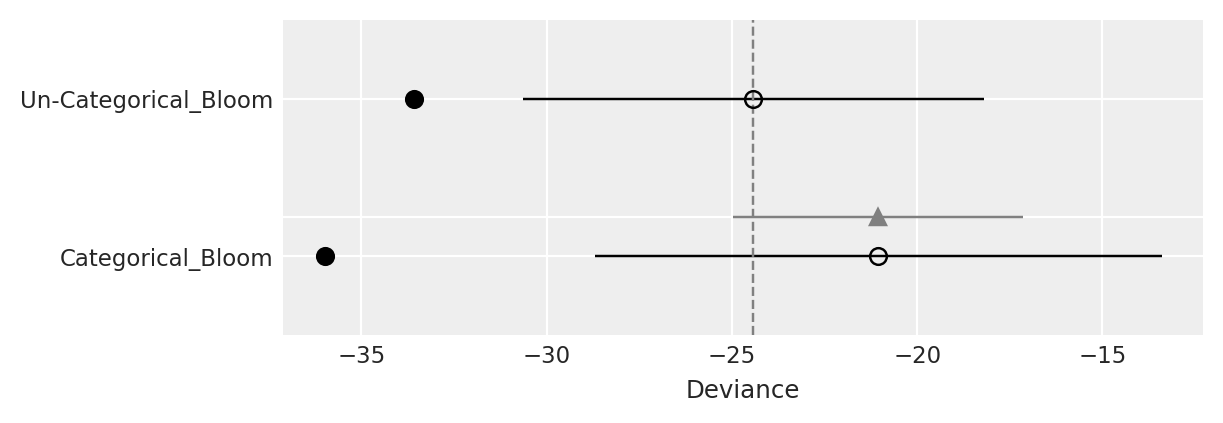

In [13]:
df_comp_WAIC = az.compare(
    {"Categorical_Bloom": Cat_bloom_sample, "Un-Categorical_Bloom": bloom_sample},
    ic="WAIC",
    scale="deviance",
)
az.plot_compare(df_comp_WAIC);

The simpler model from the chapter performed better than the one which included the bed categorical variables inside the model.

In [14]:
# inspect the bed model posterior
az.summary(Cat_bloom_sample).T

,alpha,"betaWS[0,0]","betaWS[0,1]","betaWS[0,2]","betaWS[1,0]","betaWS[1,1]","betaWS[1,2]","betaWS[2,0]","betaWS[2,1]","betaWS[2,2]",sigma
mean,0.350,0.146,0.223,0.230,-0.039,-0.190,-0.101,-0.129,-0.107,-0.169,0.142
sd,0.028,0.057,0.059,0.056,0.058,0.059,0.056,0.068,0.067,0.068,0.025
hdi_5.5%,0.306,0.051,0.136,0.146,-0.126,-0.274,-0.193,-0.242,-0.219,-0.277,0.104
hdi_94.5%,0.392,0.232,0.322,0.328,0.055,-0.089,-0.015,-0.029,-0.006,-0.065,0.181
mcse_mean,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
mcse_sd,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
ess_mean,2936.000,3008.000,2419.000,2703.000,2630.000,3031.000,3335.000,2651.000,2559.000,2679.000,970.000
ess_sd,2936.000,2427.000,2163.000,2583.000,1361.000,2650.000,2375.000,2211.000,2032.000,2679.000,970.000
ess_bulk,2965.000,2977.000,2430.000,2732.000,2654.000,3016.000,3329.000,2647.000,2573.000,2797.000,978.000
ess_tail,1443.000,1624.000,1362.000,1069.000,1573.000,1470.000,1590.000,1441.000,1427.000,1508.000,1233.000


In [15]:
az.summary(bloom_sample).T

,alpha,beta[0],beta[1],beta[2],sigma
mean,0.350,0.206,-0.112,-0.141,0.143
sd,0.028,0.034,0.034,0.041,0.024
hdi_5.5%,0.303,0.153,-0.165,-0.209,0.106
hdi_94.5%,0.392,0.261,-0.058,-0.082,0.176
mcse_mean,0.001,0.001,0.001,0.001,0.001
mcse_sd,0.000,0.000,0.001,0.001,0.000
ess_mean,1910.000,2645.000,2316.000,2340.000,1864.000
ess_sd,1910.000,2645.000,2198.000,2340.000,1789.000
ess_bulk,1981.000,2686.000,2312.000,2380.000,1901.000
ess_tail,1536.000,1366.000,1523.000,1362.000,1403.000


In [16]:
az.summary(bloom_sample).T

,alpha,beta[0],beta[1],beta[2],sigma
mean,0.350,0.206,-0.112,-0.141,0.143
sd,0.028,0.034,0.034,0.041,0.024
hdi_5.5%,0.303,0.153,-0.165,-0.209,0.106
hdi_94.5%,0.392,0.261,-0.058,-0.082,0.176
mcse_mean,0.001,0.001,0.001,0.001,0.001
mcse_sd,0.000,0.000,0.001,0.001,0.000
ess_mean,1910.000,2645.000,2316.000,2340.000,1864.000
ess_sd,1910.000,2645.000,2198.000,2340.000,1789.000
ess_bulk,1981.000,2686.000,2312.000,2380.000,1901.000
ess_tail,1536.000,1366.000,1523.000,1362.000,1403.000


Introducing indexed effect sizes for each bed category introduces a lot of variables, which estimates of predictive accuracy penalise. This penality is overcome if there's a lot of gained predictive power coming out of the additional variables. Looking at the posterior summary for the bed variables however indicates that many of the additional parameters are consistent with being close, for each of the different beds implying the beds have low predictive power. Thus using the bed model seems to introduce more parameters into our model without the compensatory increase in predictive power.

### 8H3.

Consider again the data(rugged) data on economic development and terrain ruggedness,
examined in this chapter. One of the African countries in that example, Seychelles, is far outside
the cloud of other nations, being a rare country with both relatively high GDP and high ruggedness.
Seychelles is also unusual, in that it is a group of islands far from the coast of mainland Africa, and
its main economic activity is tourism.

(a) Focus on model m8.5 from the chapter. Use WAIC pointwise penalties and PSIS Pareto k
values to measure relative influence of each country. By these criteria, is Seychelles influencing the
results? Are there other nations that are relatively influential? If so, can you explain why?

(b) Now use robust regression, as described in the previous chapter. Modify m8.5 to use a
Student-t distribution with ν = 2. Does this change the results in a substantial way?

#### Answer to a)


He says m8.5 in the book. He must mean m8.3, as m8.5 is the tulip model, whilst m8.3 is for the country data, where the model uses different slopes and intercepts depending upon whether you are inside or outside of Africa - $\mu_i = \alpha_{CID[i]} + \beta_{CID[i]}(r_i-\bar{r})$ where CID[i] is the categorical indicator variable.

In [17]:
Rugged = pd.read_csv("./data/rugged.csv", delimiter=";")

In [18]:
# pre shape check
Rugged.shape

(234, 51)

In [19]:
# get the complete cases
Complete = Rugged.dropna(axis=0, subset=["rgdppc_2000"])

In [20]:
# compare shape after dropping the Nans
Complete.shape

(170, 51)

In [21]:
# lets standardise the variables like how he does in the book
Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
Complete["s_log_gdp"] = Complete["log_gdp"] / np.mean(Complete["log_gdp"])
Complete["s_rugged"] = Complete["rugged"] / np.max(Complete["rugged"])

<ipython-input-21-66ed13506f36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
<ipython-input-21-66ed13506f36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["s_log_gdp"] = Complete["log_gdp"] / np.mean(Complete["log_gdp"])
<ipython-input-21-66ed13506f36>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Now we've standardised the data, let's reimplement model m8.3, the interaction model from the book.

In [22]:
with pm.Model() as m8_3:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Normal("b", 1, 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", Complete.s_rugged)
    cid = pm.intX(pm.Data("cid", Complete.cont_africa))
    mu = pm.Deterministic("mu", a[cid] + b[cid] * (x - 0.215))
    l_gdp = pm.Normal("l_gdp", mu=mu, sd=sigma, observed=Complete.s_log_gdp)
    m8_3_samples = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


In [23]:
az.summary(m8_3_samples, var_names=["a", "b"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.050,0.011,1.032,1.066,0.000,0.000,1486.0,1486.0,1482.0,774.0,1.00
a[1],0.889,0.016,0.864,0.916,0.000,0.000,1997.0,1996.0,1982.0,878.0,1.00
b[0],-0.108,0.053,-0.201,-0.031,0.001,0.001,1707.0,1363.0,1712.0,822.0,1.01
b[1],0.197,0.078,0.076,0.328,0.002,0.001,1525.0,1384.0,1532.0,783.0,1.00


The parameter means and standard deviations match well with those given in the book (though the indices are exchanged).

We have our model, so let's plot it. First let's check the model implemented above reproduces what was done in the book.

In [24]:
x = np.linspace(0, 1, 50)
with m8_3:
    pm.set_data({"x": x, "cid": np.zeros(50, dtype=int)})
    other_ppc = pm.sample_posterior_predictive(m8_3_samples, 1000, var_names=["mu", "l_gdp"])

    pm.set_data({"x": x, "cid": np.zeros(50, dtype=int) + 1})
    africa_ppc = pm.sample_posterior_predictive(m8_3_samples, 1000, var_names=["mu", "l_gdp"])

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


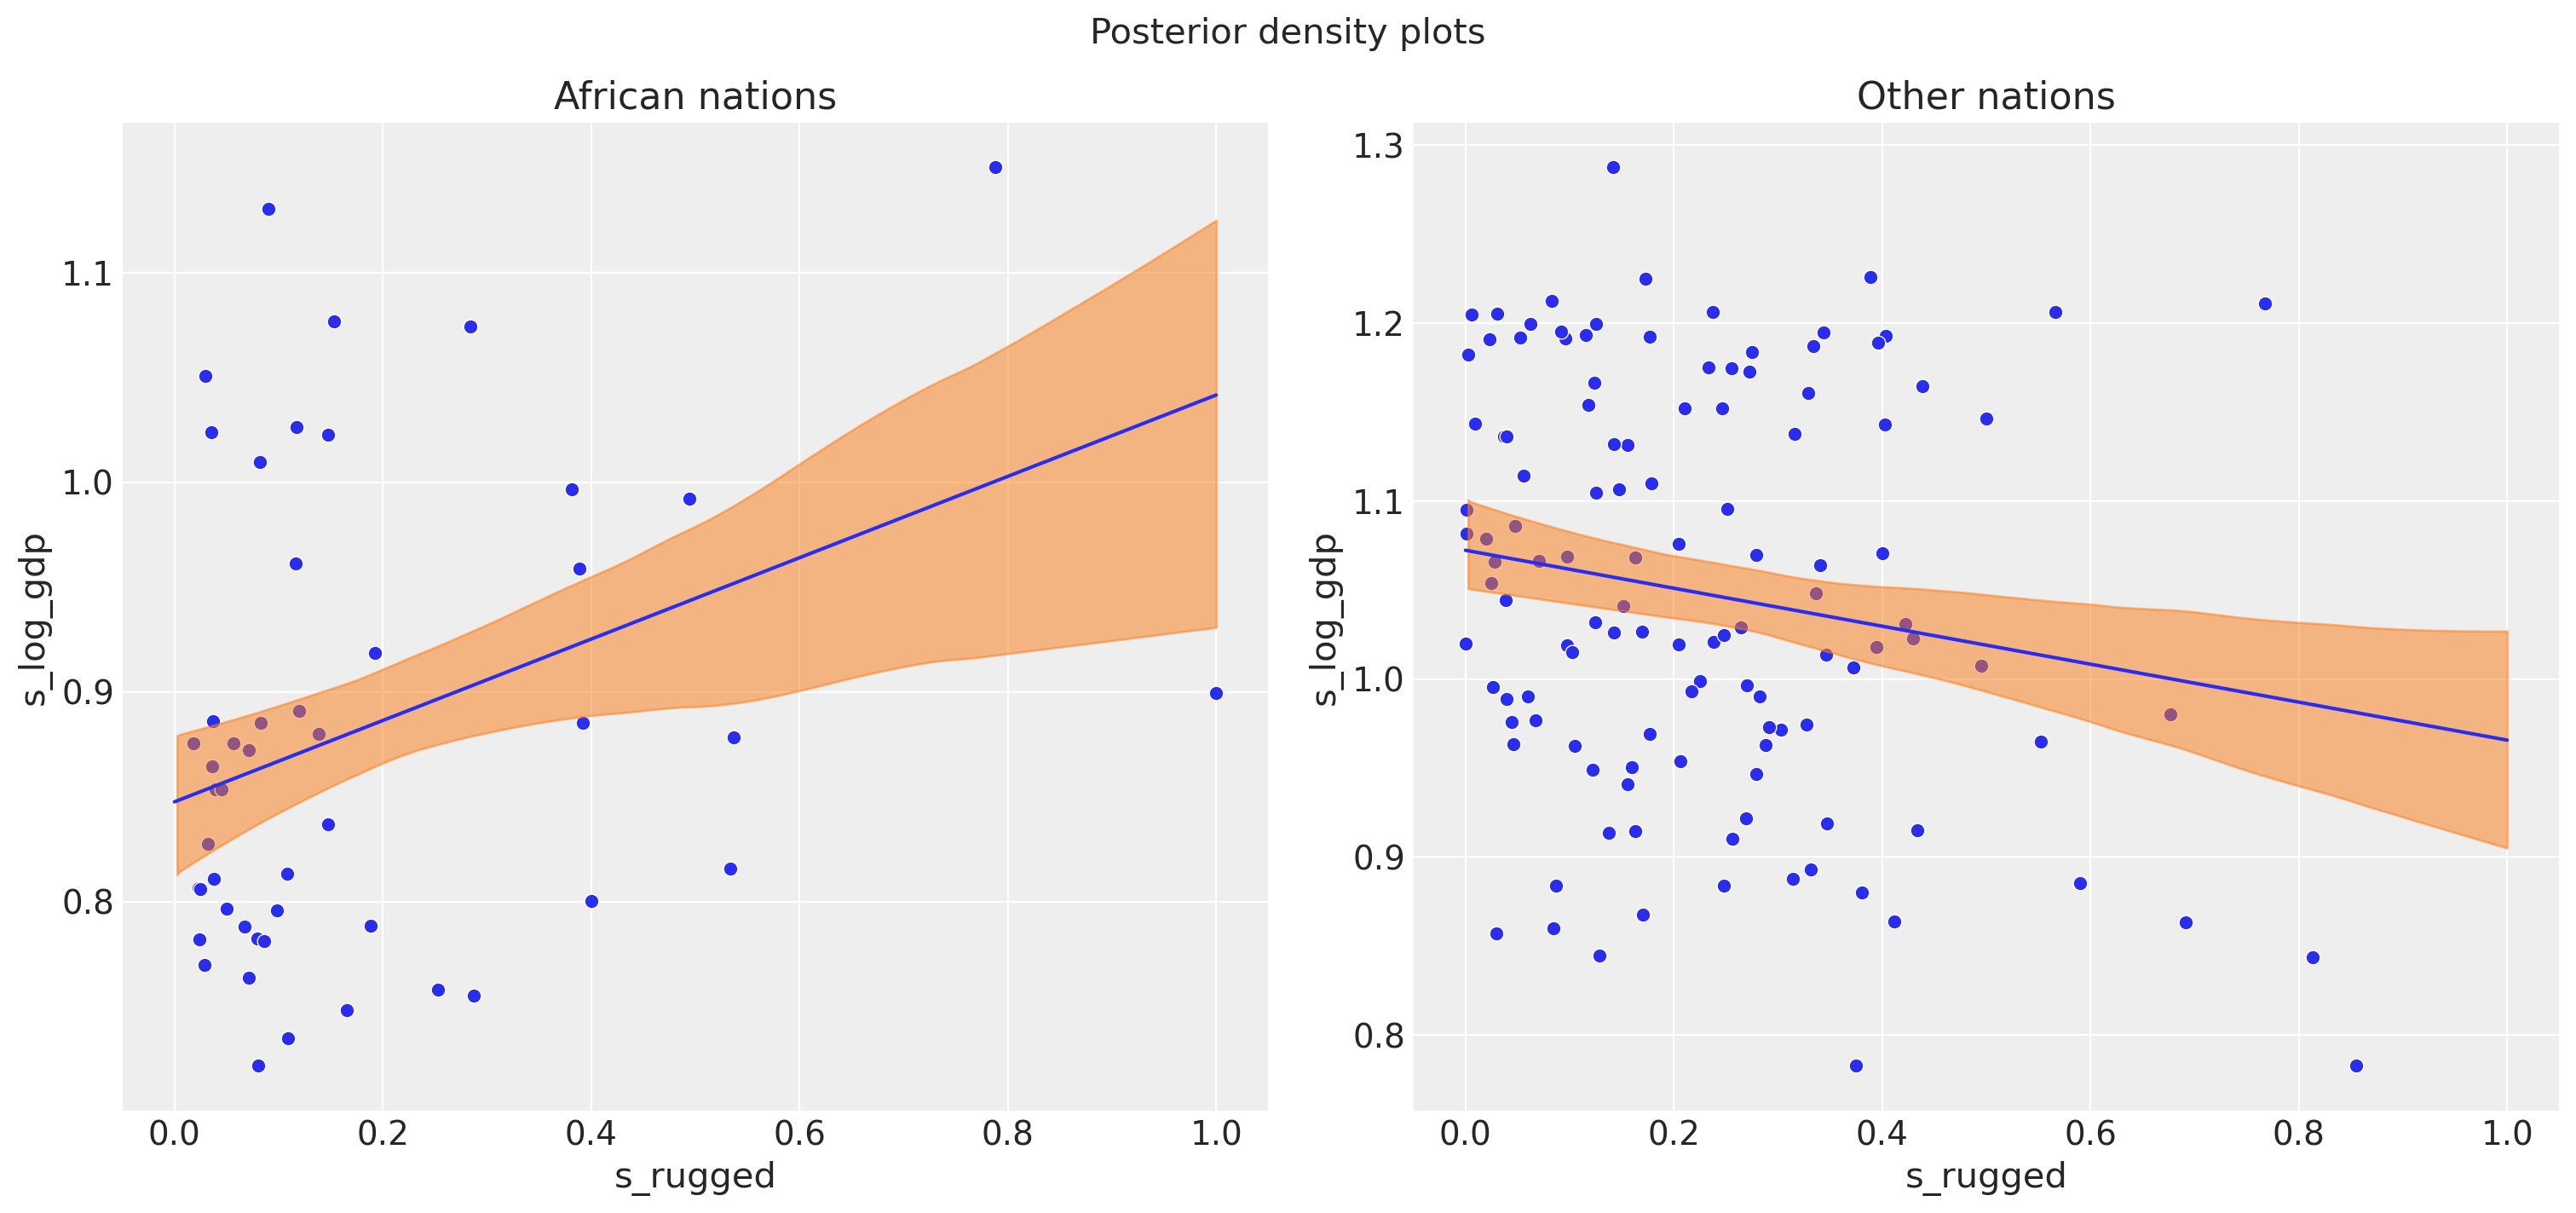

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle("Posterior density plots", fontsize=15)

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa == 1], ax=axs[0])
az.plot_hdi(x, africa_ppc["mu"], ax=axs[0])
axs[0].plot(x, africa_ppc["mu"].mean(0))
axs[0].set_title("African nations")

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa == 0], ax=axs[1])
az.plot_hdi(x, other_ppc["mu"], ax=axs[1])
axs[1].plot(x, other_ppc["mu"].mean(0))
axs[1].set_title("Other nations");

In [26]:
# compute the waic and psis on the deviance scale
m8_3_waic = az.waic(m8_3_samples, pointwise=True, scale="deviance")
m8_3_LOO = az.loo(m8_3_samples, pointwise=True, scale="deviance")

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [27]:
# get the pointwise values for these distributions
pareto_k = m8_3_LOO.pareto_k.values

In [28]:
pareto_k.max()

0.5412412568696429

In [29]:
# get the places with the biggish pareto_k values
big = Complete[pareto_k >= 0.5]

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


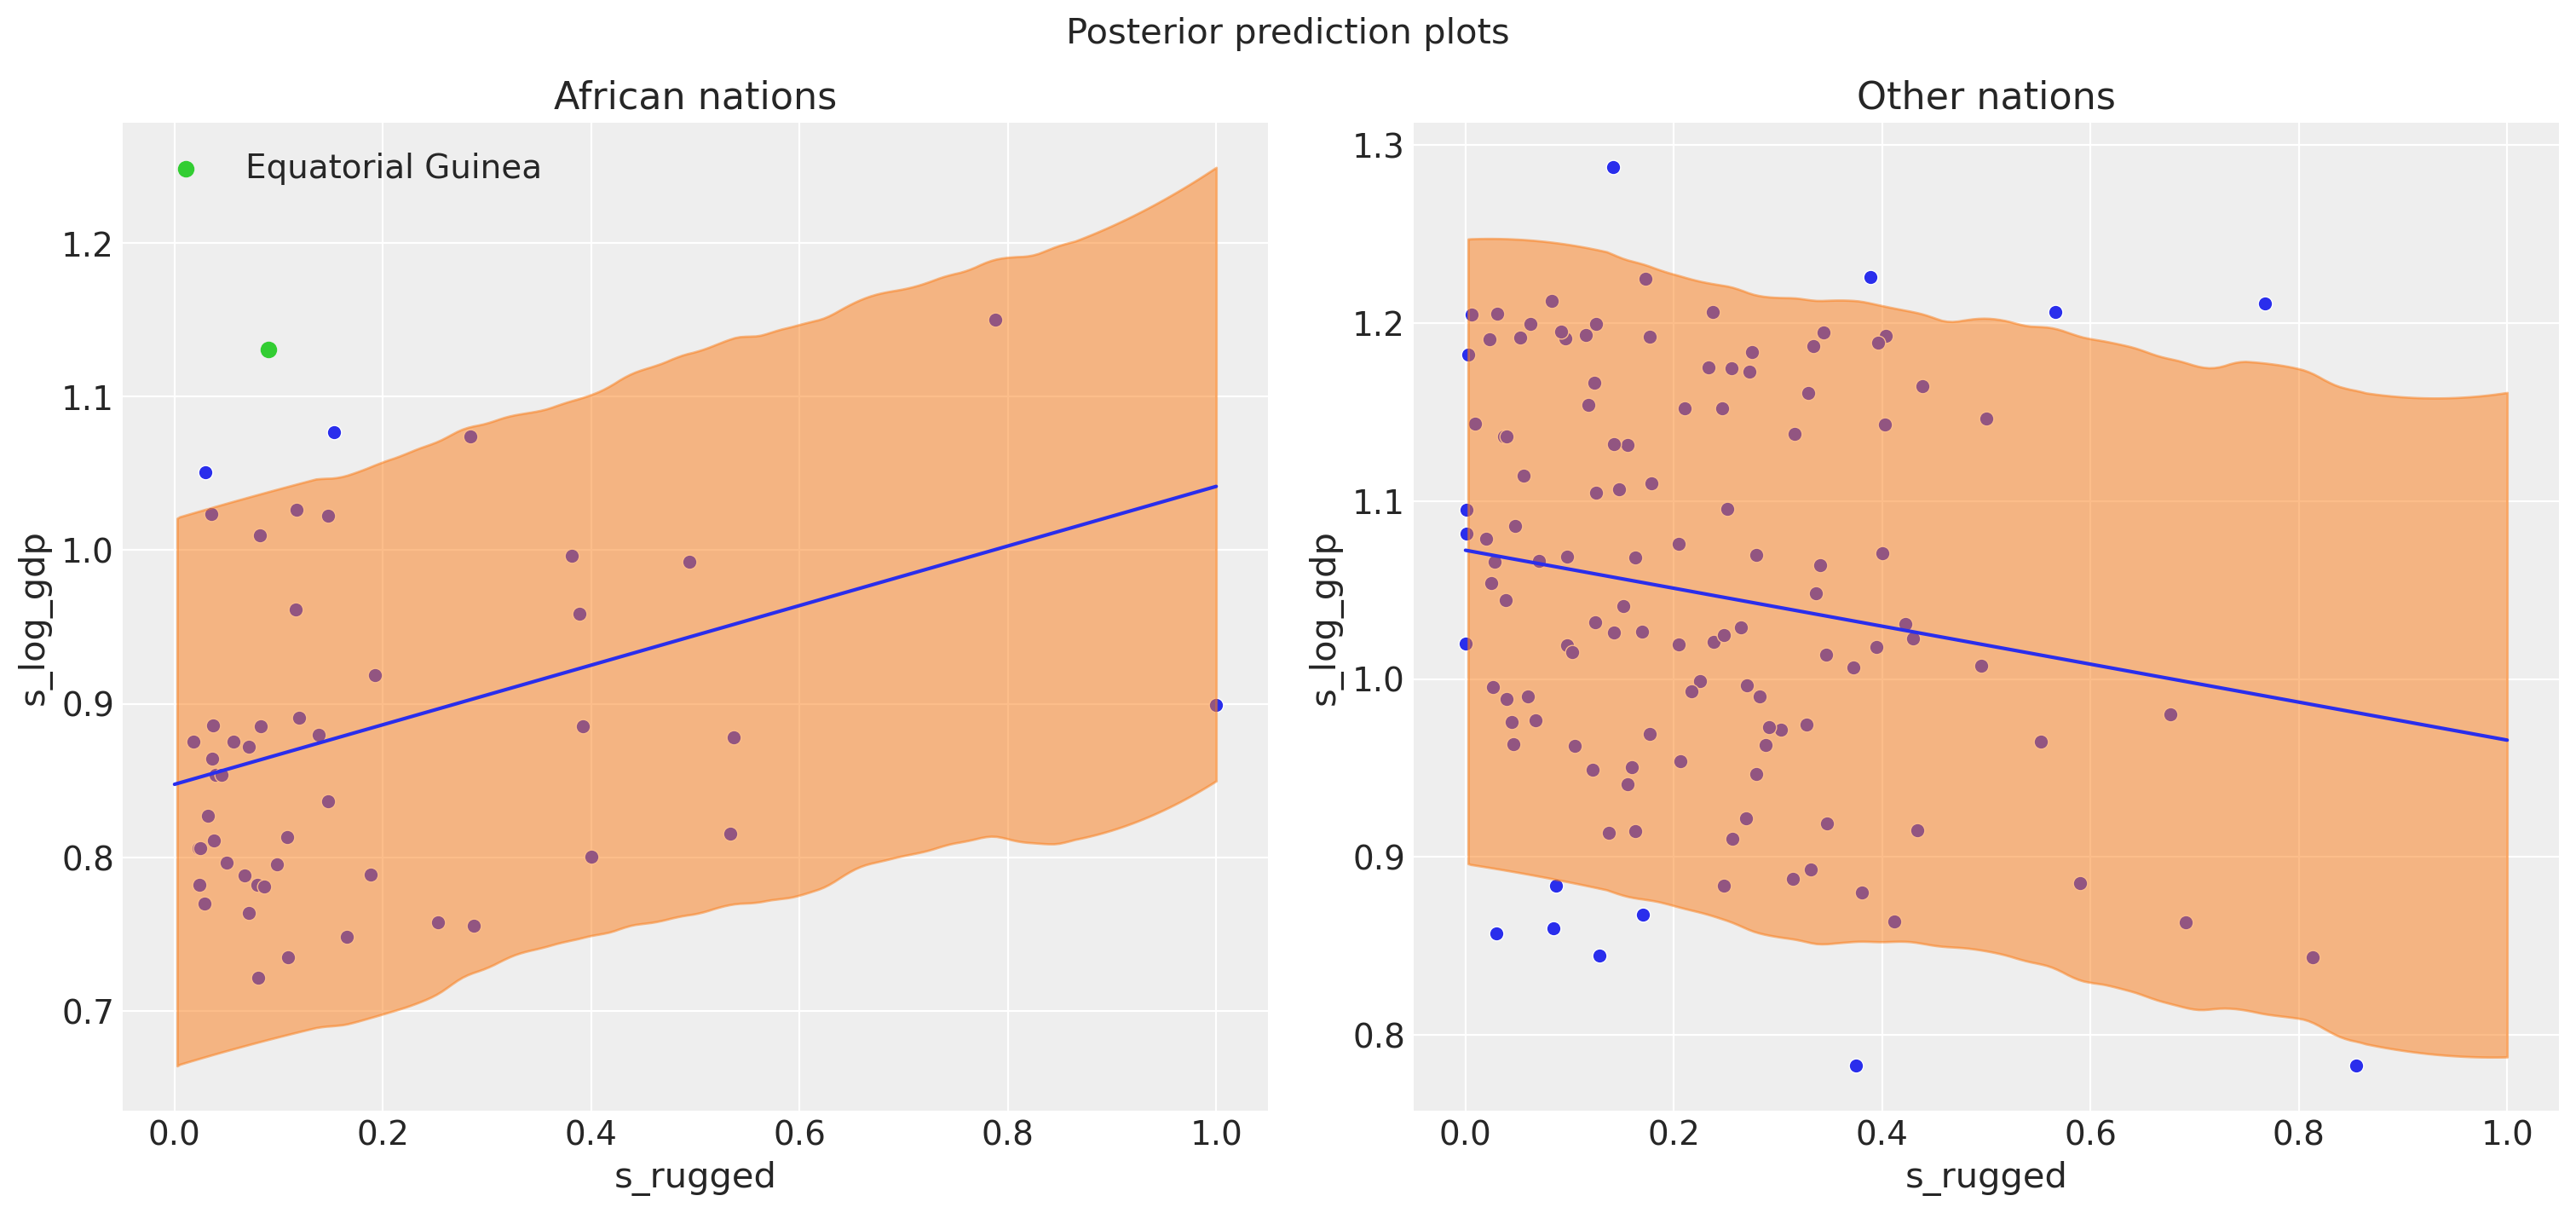

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle("Posterior prediction plots", fontsize=15)

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa == 1], ax=axs[0])
az.plot_hdi(x, africa_ppc["l_gdp"], ax=axs[0])
axs[0].plot(x, africa_ppc["mu"].mean(0))
axs[0].set_title("African nations")

axs[0].set_title("African nations")
for i in big[big.cont_africa == 1].country.values:
    axs[0].scatter(
        big[big.country == i].s_rugged,
        big[big.country == i].s_log_gdp,
        label=i,
        c="limegreen",
    )
axs[0].legend()


sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa == 0], ax=axs[1])
az.plot_hdi(x, other_ppc["l_gdp"], ax=axs[1])
axs[1].plot(x, other_ppc["mu"].mean(0))
axs[1].set_title("Other nations");

The highest pareto k value occurs for Lesotho. At first glance, this may seem fairly surprising as it appears closer to the mean than the point immediately to the left of it. However, the PSIS is averaged over the posterior, and the posterior is much broader near to Letsotho than other points, as the sparsity of data means the typical log likelihood of this particular value will be quite small. But we don't have much data around this point, meaning we don't have a good out of sample estimate for points like Lesotho as it's so far away from the bulk of our data points, limiting our predictive power for countries in Africa that are this rugged.

#### Answer to b):

In [31]:
with pm.Model() as Robust_m8_3:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Normal("b", 1, 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", Complete.s_rugged)
    cid = pm.intX(pm.Data("cid", Complete.cont_africa))
    mu = pm.Deterministic("mu", a[cid] + b[cid] * (x - 0.215))
    l_gdp = pm.StudentT("l_gdp", nu=2, mu=mu, sd=sigma, observed=Complete.s_log_gdp)
    Robust_m8_3_samples = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


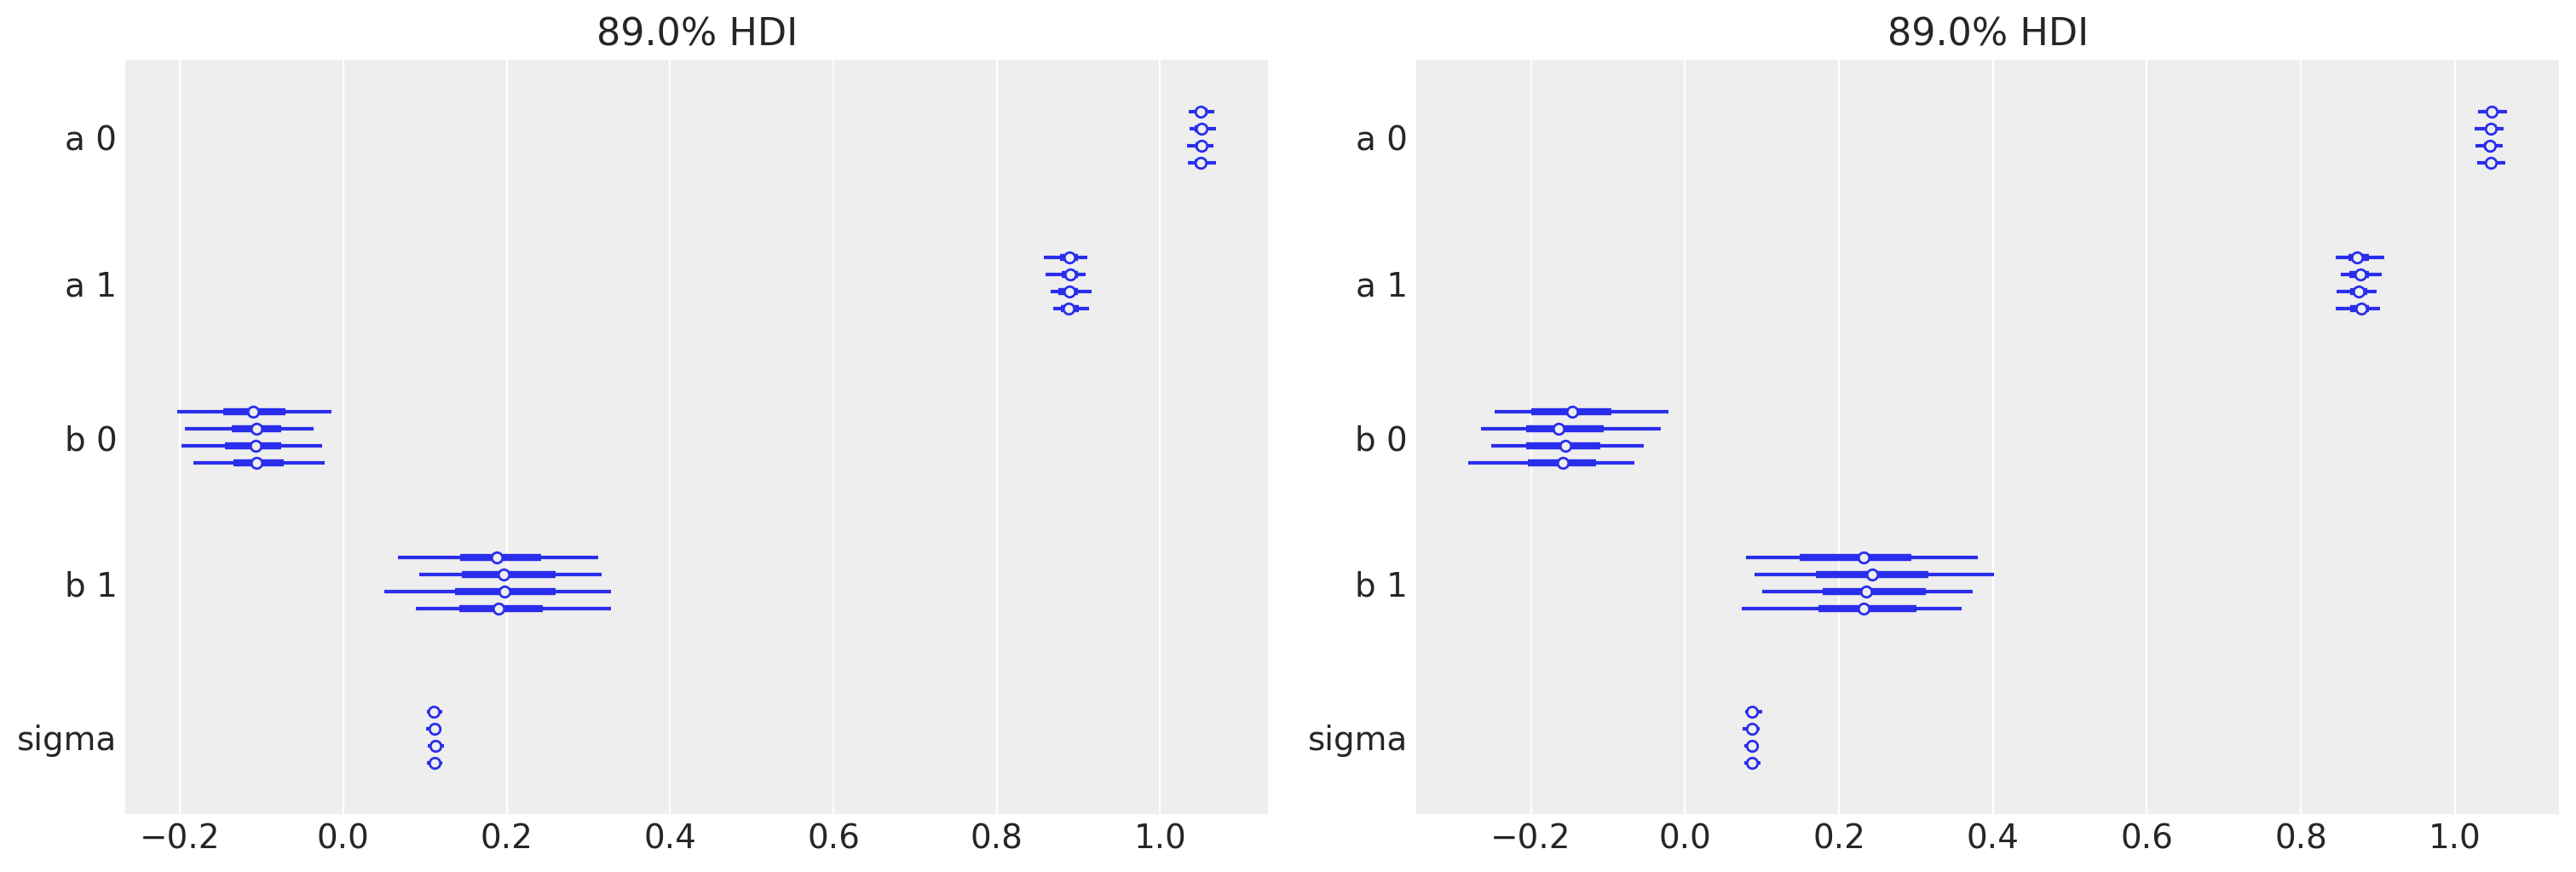

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Standard Linear regression")
az.plot_forest(m8_3_samples, ax=axs[0], var_names=["a", "b", "sigma"])
axs[1].set_title("Robust Linear regression")
az.plot_forest(Robust_m8_3_samples, ax=axs[1], var_names=["a", "b", "sigma"]);

These models are not spectacularly different from one another, that is, non of the data had a major impact on the parameter posteriors. The standard regression is on the left hand side whilst the robust regression is on the right hand side. There's been a marginal increase in the mean of the $\beta_1$ parameter of Africa. This is possibly becuase Lesotho is marginally less influential in the robust regression model as the mean line doesn't "dragged" around as much by this vaguely, weakly (not even really) extreme value.

In [33]:
x = np.linspace(0, 1, 50)
with Robust_m8_3:
    pm.set_data({"x": x, "cid": np.zeros(50, dtype=int)})
    Robust_other_ppc = pm.sample_posterior_predictive(
        Robust_m8_3_samples, 1000, var_names=["mu", "l_gdp"]
    )

    pm.set_data({"x": x, "cid": np.zeros(50, dtype=int) + 1})
    Robust_africa_ppc = pm.sample_posterior_predictive(
        Robust_m8_3_samples, 1000, var_names=["mu", "l_gdp"]
    )

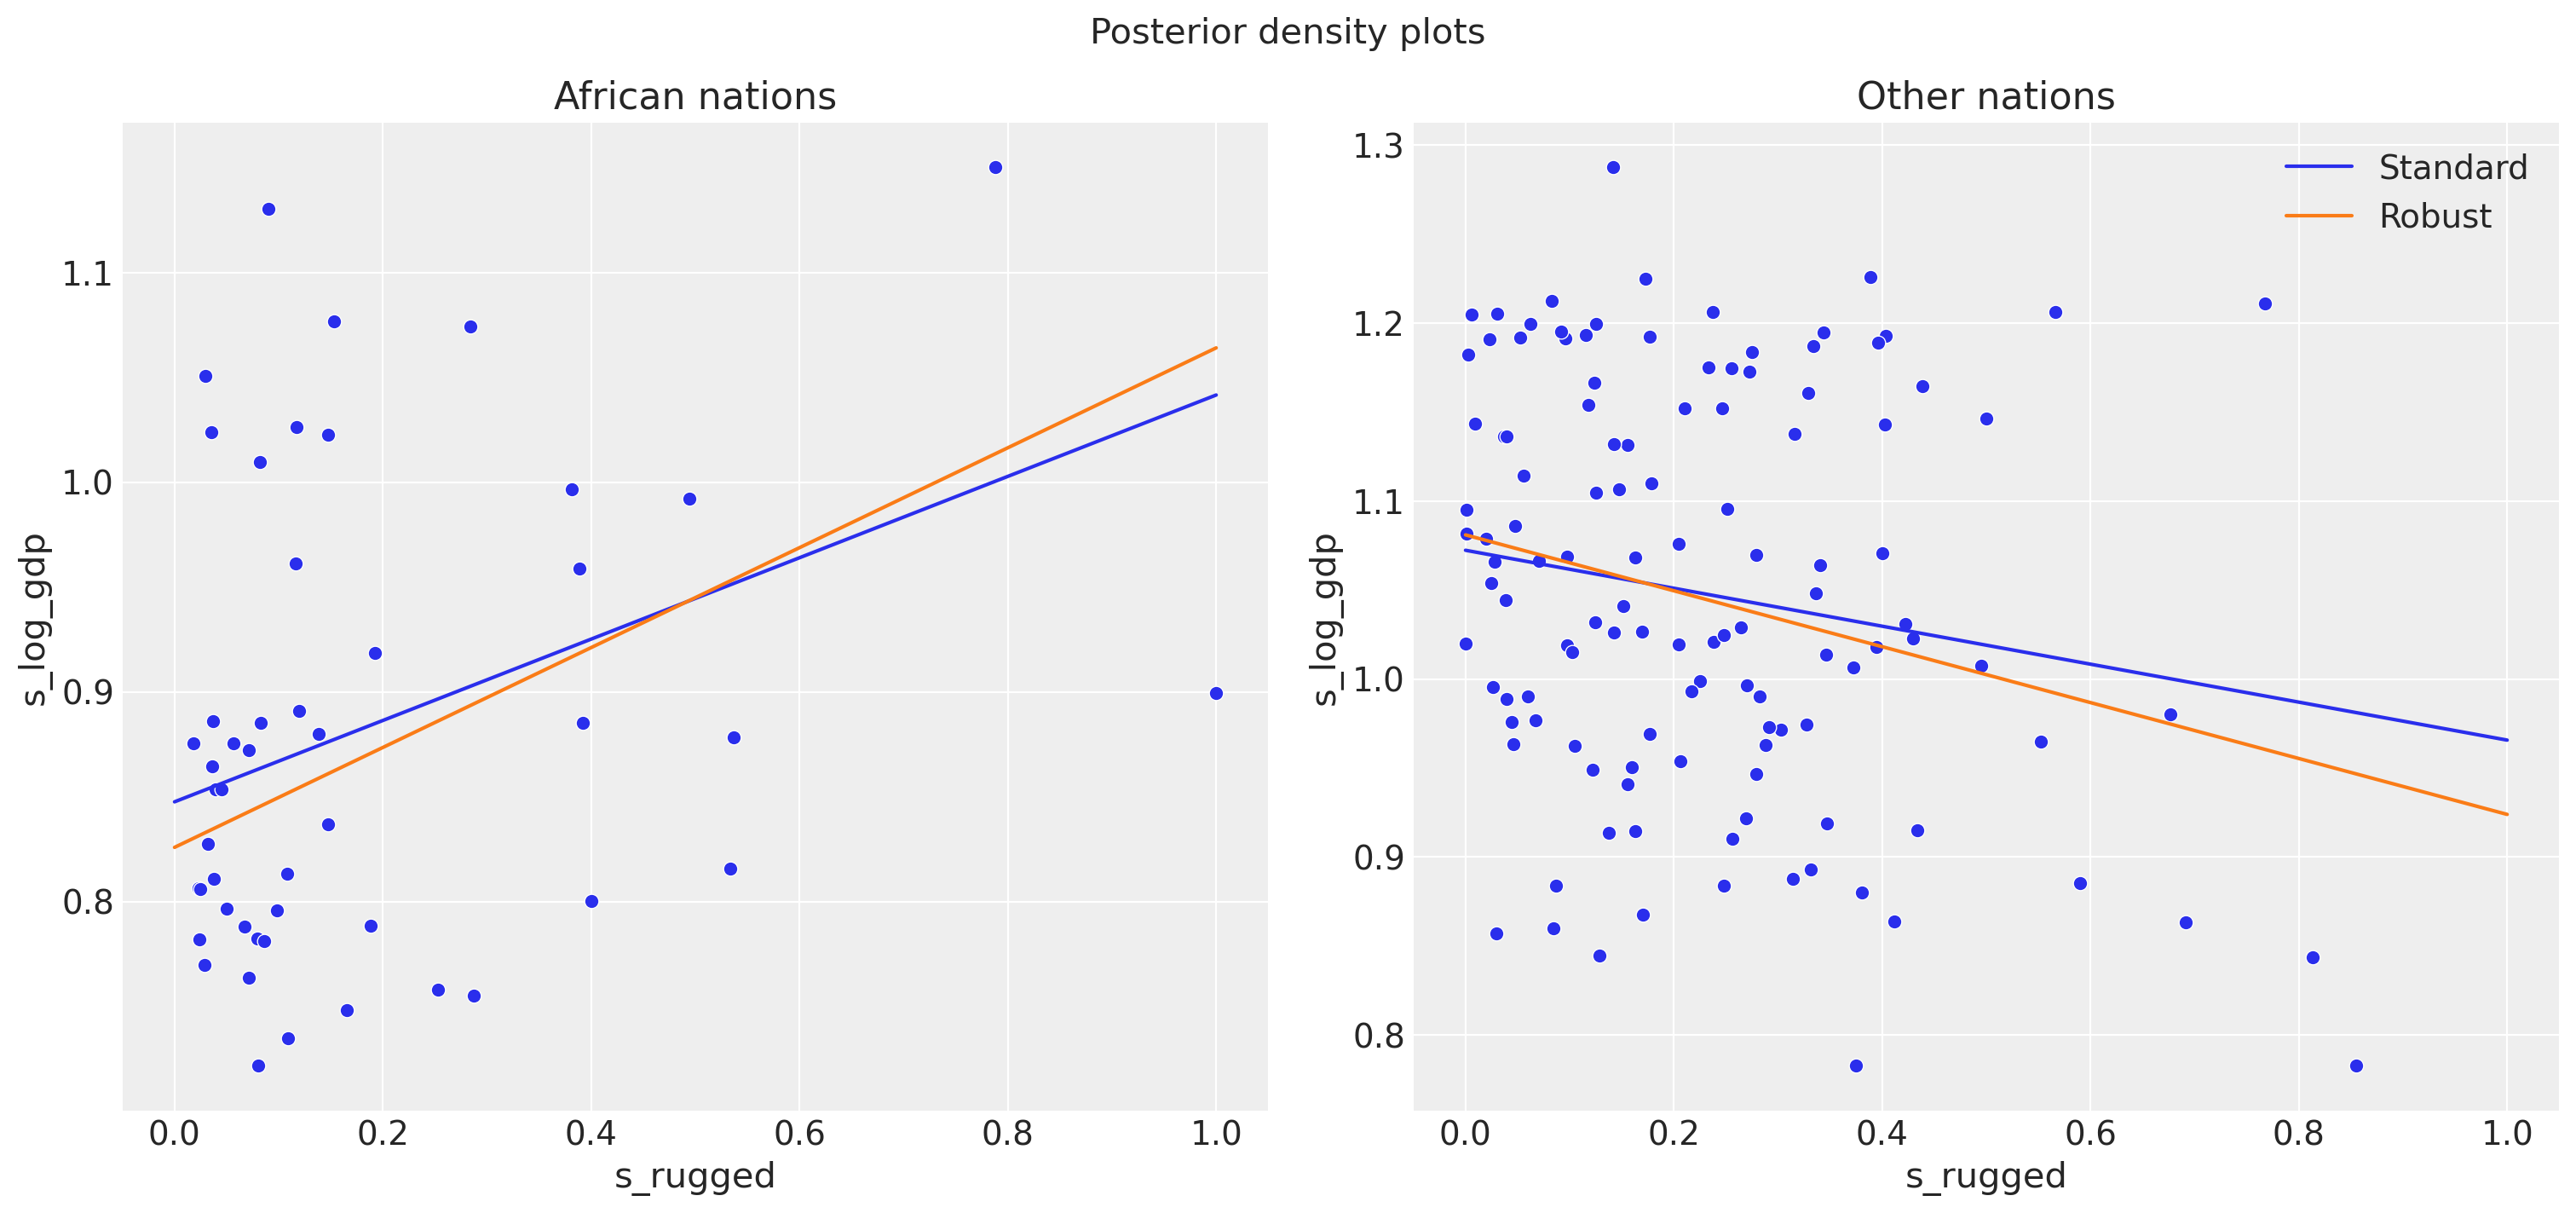

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle("Posterior density plots", fontsize=15)

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa == 1], ax=axs[0])
axs[0].plot(x, africa_ppc["mu"].mean(0))
axs[0].plot(x, Robust_africa_ppc["mu"].mean(0))
axs[0].set_title("African nations")

sns.scatterplot(x="s_rugged", y="s_log_gdp", data=Complete[Complete.cont_africa == 0], ax=axs[1])

axs[1].plot(x, other_ppc["mu"].mean(0), label="Standard")
axs[1].plot(x, Robust_other_ppc["mu"].mean(0), label="Robust")
axs[1].set_title("Other nations")

plt.legend();

Regression in the non African countries remains broadly unchanged low rugged countries, where there's a lot of data. That is to say, the bulk of the data is far less impacted by any extreme values in the out of Africa nations. Only in regions with sparse data do the models disagree. Within Africa however, we can see that Lesotho has a disproportionate impact on low rugged countries, for which we have a lot of data.  If we inspect the African regression we can see that the Robust regression has a higher incline, being dragged down less by Lesotho than the conventional Gaussian regression. The fact that the robust regression disagrees with the conventional regression in areas with large amounts of data goes some of the way to explaining why the extreme k>5 was flagged in the African data and not the out of Africa data, despite the gradients changing for both. 

### 8H5.

Consider the data(Wines2012) data table. These data are expert ratings of 20 different French
and American wines by 9 different French and American judges. Your goal is to model score, the
subjective rating assigned by each judge to each wine. I recommend standardizing it. In this problem,
consider only variation among judges and wines. Construct index variables of judge and wine and
then use these index variables to construct a linear regression model. Justify your priors. You should
end up with 9 judge parameters and 20 wine parameters. How do you interpret the variation among
individual judges and individual wines? Do you notice any patterns, just by plotting the differences?
Which judges gave the highest/lowest ratings? Which wines were rated worst/best on average?

In [35]:
wine = pd.read_csv("./data/Wines2012.csv", delimiter=";")

In [36]:
wine

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0
...,...,...,...,...,...,...
175,Francis Schott,red,F2,12.0,1,1
176,Francis Schott,red,G2,15.0,0,1
177,Francis Schott,red,H2,16.0,1,1
178,Francis Schott,red,I2,7.0,1,1


In [37]:
np.min(wine.score), np.max(wine.score), np.mean(wine.score)

(7.0, 19.5, 14.2)

In [38]:
# indix the categories
wine.judge = pd.Categorical(wine.judge)
wine["judge_index"] = wine.judge.cat.codes

wine.wine = pd.Categorical(wine.wine)
wine["wine_index"] = wine.wine.cat.codes

In [39]:
wine

,judge,flight,wine,score,wine.amer,judge.amer,judge_index,wine_index
0,Jean-M Cardebat,white,A1,10.0,1,0,3,0
1,Jean-M Cardebat,white,B1,13.0,1,0,3,2
2,Jean-M Cardebat,white,C1,14.0,0,0,3,4
3,Jean-M Cardebat,white,D1,15.0,0,0,3,6
4,Jean-M Cardebat,white,E1,8.0,1,0,3,8
...,...,...,...,...,...,...,...,...
175,Francis Schott,red,F2,12.0,1,1,1,11
176,Francis Schott,red,G2,15.0,0,1,1,13
177,Francis Schott,red,H2,16.0,1,1,1,15
178,Francis Schott,red,I2,7.0,1,1,1,17


In [40]:
wine["wine_index"].drop_duplicates().shape, wine["judge_index"].drop_duplicates().shape

((20,), (9,))

Let's scale the score in the wine model such that min = 0 and max = 1

In [41]:
wine["s_score"] = (wine.score - np.min(wine.score)) / (np.max(wine.score) - np.min(wine.score))

Let's turn the wine scores into z-scores.

In [42]:
wine["s_score"] = (wine.score - np.mean(wine.score)) / np.std(wine.score)

In [43]:
wine.wine_index

0       0
1       2
2       4
3       6
4       8
       ..
175    11
176    13
177    15
178    17
179    19
Name: wine_index, Length: 180, dtype: int8

In [44]:
wine.columns

Index(['judge', 'flight', 'wine', 'score', 'wine.amer', 'judge.amer',
       'judge_index', 'wine_index', 's_score'],
      dtype='object')

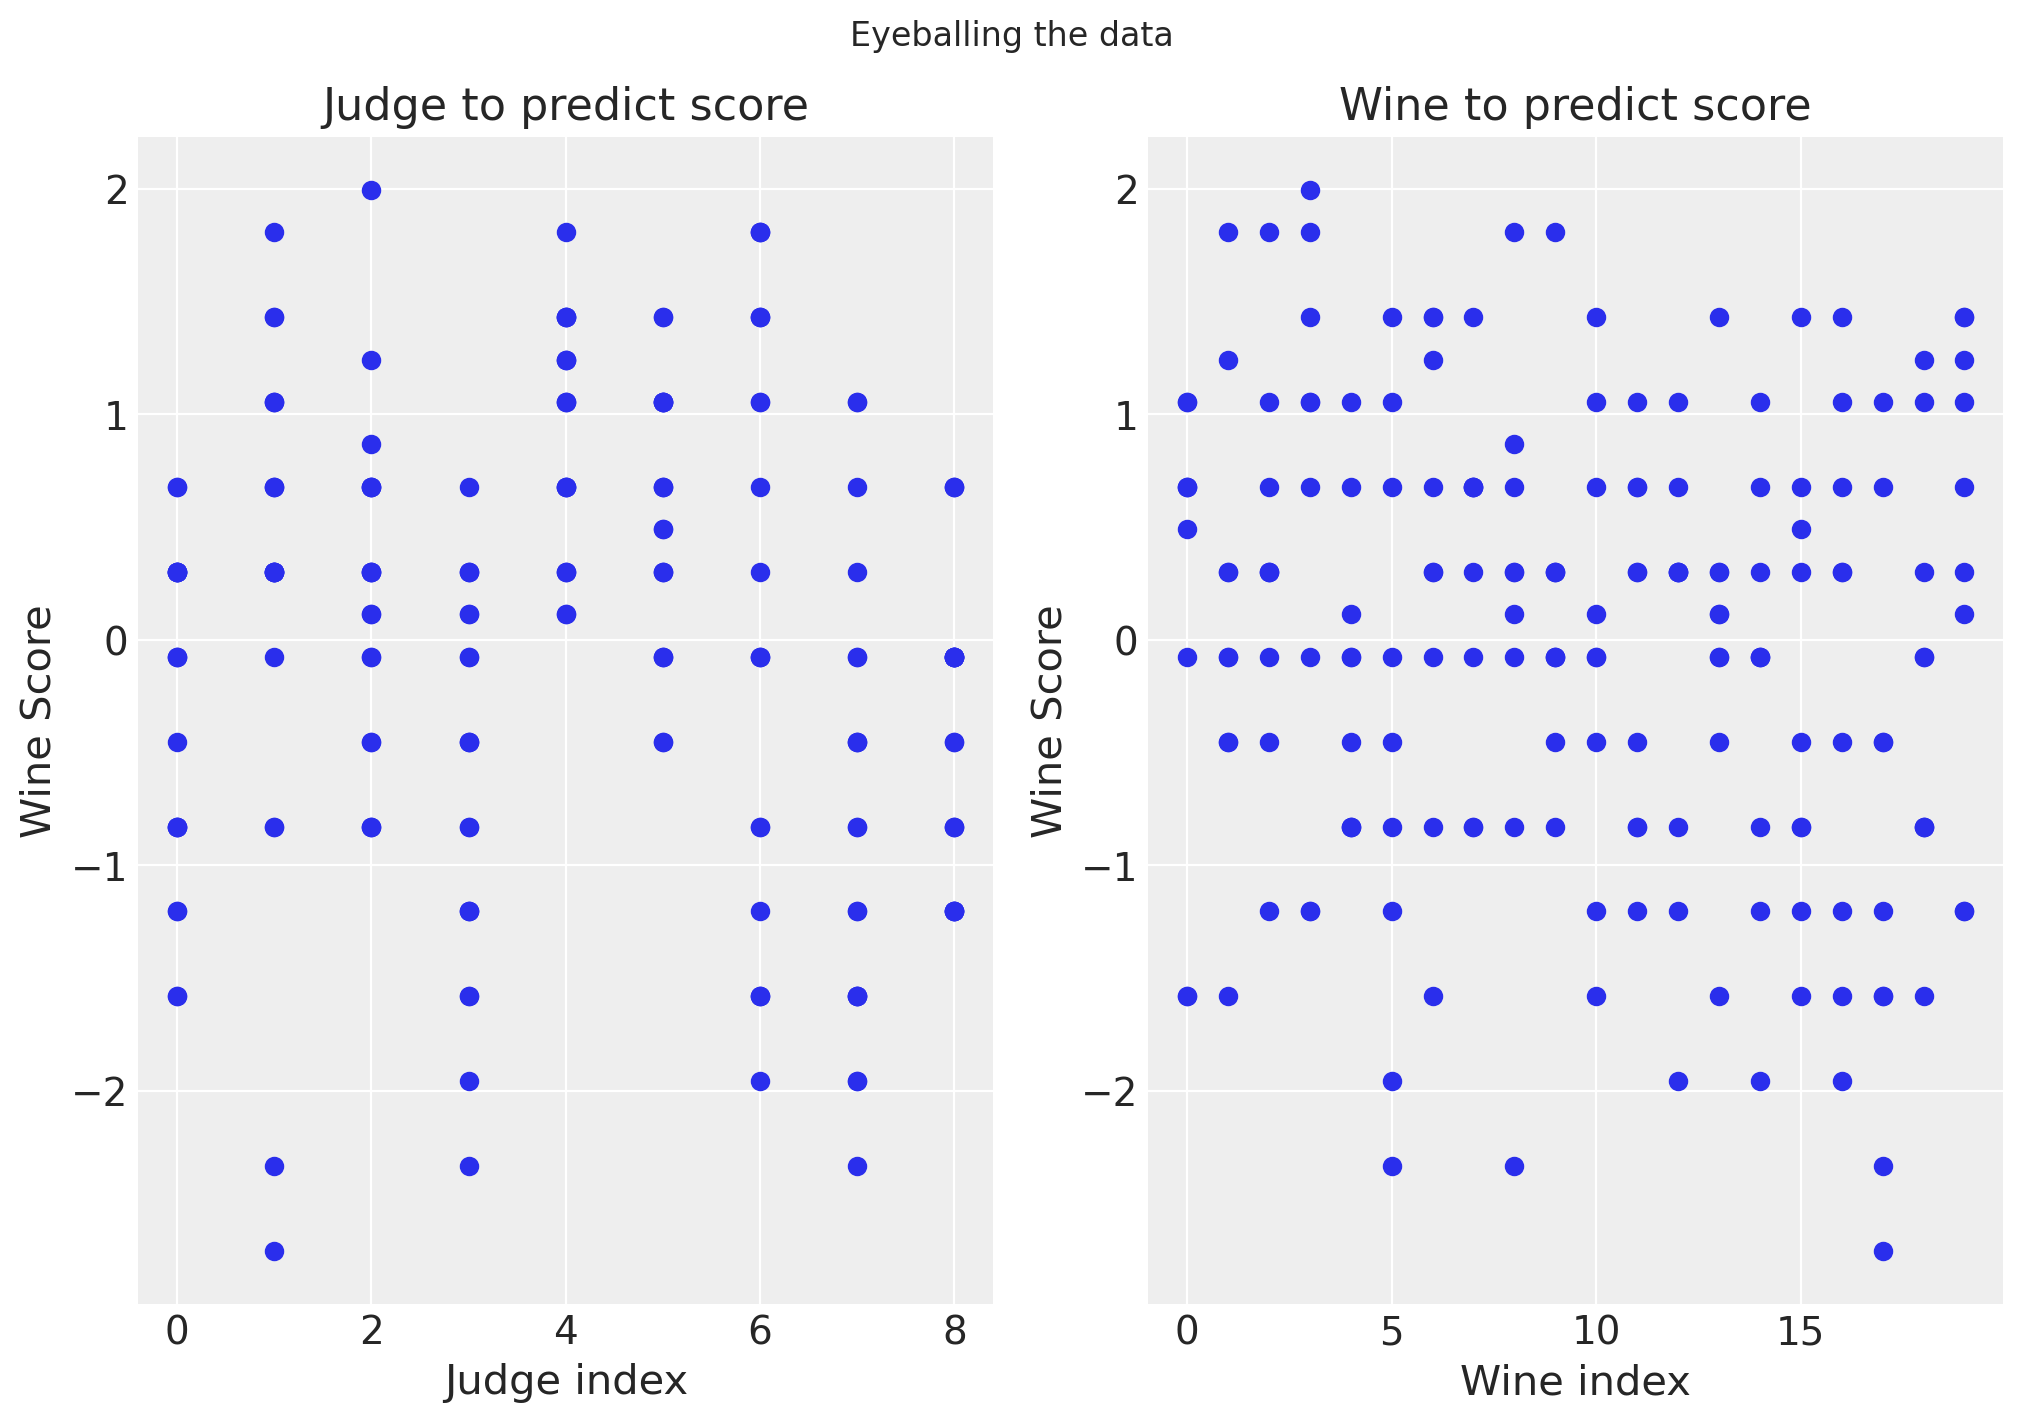

In [45]:
# Visualise the data
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

plt.suptitle("Eyeballing the data")

axs[0].scatter(wine.judge_index, wine["s_score"])
axs[0].set_title("Judge to predict score")
axs[0].set_xlabel("Judge index")
axs[0].set_ylabel("Wine Score")

axs[1].scatter(wine.wine_index, wine["s_score"])
axs[1].set_title("Wine to predict score")
axs[1].set_xlabel("Wine index")
axs[1].set_ylabel("Wine Score");

As can be seen from the above data, knowing the wine by itself doesn't seem to obviously narrow down what you'd expect to see in the data. However, knowing which judge you have might be more useful information. As seen for judges 4 and 6, you might expect any generic wine that you give them to get an above average rating. They've sampled 20 wines, which isn't a lot of data, but it should be enough to do some inference. Due to this sparsity the model shouldn't get too excited by the data, as maybe there's some other explanatory variable determining what's going on with those "overly positive" judges. Maybe they just won the lottery making them very happy that day. In future they might have a bad day, in which case they might give unfavourable ratings. Therefore we'll regularize our model to prevent overfitting.

Let's assume the following DAG

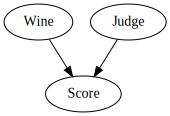

In [46]:
Dag = CausalGraphicalModel(
    nodes=["Judge", "Wine", "Score"], edges=[("Judge", "Score"), ("Wine", "Score")]
)

# draw return a graphviz `dot` object, which jupyter can render

Dag.draw()

And we give it this regression model, and add Gaussian noise around the middle

$\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]}$

Where $\alpha$ is the effect of being a certain judge, and $\beta$ is the effect of being a certain wine on the score outcome. We assume no interaction in the model at this point.

In [47]:
wine.groupby("wine").mean()["s_score"].std(), wine.groupby("judge").mean()["s_score"].std()

(0.3391405978089046, 0.5568056851777015)

Given these interpretations and the scatter plots above, we now have the task of assigning priors. Judging from the scatters, the mean for any candidate should be around zero. I could assign poorly formed, broad priors of around 2. This means that you'd expect about 33% (see 68-95-99 rule) of the judges to assign to have mean Z-scores of more than 2. This is preposterously large given the scatter plots above. Even using 1 here seems silly. Looking at the code above, we can see that the standard deviation in the average score of the each wine, is 0.33 and of the judges is around 0.55. 

We'll run three models, one with std of one on the priors and another with a stricter regularization on the parameters and then do some model comparison.

As these are z scores, we expect a maximum standard deviation of around 1 given that we knew nothing else about the data. For information theoretic reasons, the data cannot become more dispersed on average once we know the wine or the judge. At worst the wine and judge can be independent of the score, in which case the model will just be guessing z-scores at random. This places an upper bound on our expectations of the noise about $\mu$. To encode this in the model, we can just make sigma ~ Exp(1).

We'll also throw in an "over-regularized" model just to see what happens. By placing unreasonably narrow Normal priors on the alpha and beta parameters, both with a standard deviation of 0.1. This model should have a very poor WAIC score as it refuses to learn.

In [48]:
with pm.Model() as wine_score:
    alpha = pm.Normal("alpha", 0, 1, shape=(9))
    beta = pm.Normal("beta", 0, 1, shape=(20))
    sigma = pm.Exponential("sigma", 1)
    mu = (
        alpha[wine.judge_index]
        + beta[
            wine.wine_index,
        ]
    )
    wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    wine_post = pm.sample(draws=1000, chains=4, return_inferencedata=True)

with pm.Model() as regularized_wine_score:
    alpha = pm.Normal("alpha", 0, 0.55, shape=(9))
    beta = pm.Normal("beta", 0, 0.33, shape=(20))
    sigma = pm.Exponential("sigma", 1)
    mu = (
        alpha[wine.judge_index]
        + beta[
            wine.wine_index,
        ]
    )
    regularized_wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    regularized_wine_post = pm.sample(draws=1000, chains=4, return_inferencedata=True)

with pm.Model() as over_regularized_wine_score:
    alpha = pm.Normal("alpha", 0, 0.1, shape=(9))
    beta = pm.Normal("beta", 0, 0.1, shape=(20))
    sigma = pm.Exponential("sigma", 1)
    mu = (
        alpha[wine.judge_index]
        + beta[
            wine.wine_index,
        ]
    )
    over_regularized_wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    over_regularized_wine_post = pm.sample(draws=1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [49]:
compare_df = az.compare(
    {
        "wine_score": wine_post,
        "regularized_wine_score": regularized_wine_post,
        "over_regularized_wine_score": over_regularized_wine_post,
    },
    ic="waic",
    scale="deviance",
)
compare_df

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
regularized_wine_score,0,471.299,18.7038,0,0.957983,18.4533,0,True,deviance
wine_score,1,481.384,25.0833,10.0849,0.0337177,19.0942,4.34711,True,deviance
over_regularized_wine_score,2,498.323,4.0428,27.0234,0.00829919,17.6449,10.4822,False,deviance


As can be seen, the regularized model performed best. The model with overly broad priors comes in second place, whilst the over regularized model does the worst as expected. The over regularized model essentially just refuses to believe that know the wine or the judge is in anyway helpful for knowing the score, in spite of evidence to the contrary, hence it will make poor predictions about future, out of sample data, which is reflected in the WAIC score.

In [50]:
alpha_summary = az.summary(regularized_wine_post, var_names=["alpha"])
beta_summary = az.summary(regularized_wine_post, var_names=["beta"])

In [51]:
# make hacky data frames to use in the middle
tempdf = wine[["judge_index", "judge.amer"]].drop_duplicates().sort_values(by=["judge_index"])
tempdf2 = wine[["wine_index", "wine.amer"]].drop_duplicates().sort_values(by=["wine_index"])

In [52]:
# match up the wine and judges with their associated effect size
tempdf["judge_effect"] = alpha_summary["mean"].values
tempdf2["wine_effect"] = beta_summary["mean"].values

We now have data frames matching the judges and wine scores as to whether or not they're American

<ipython-input-53-0e392a360ddc>:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();


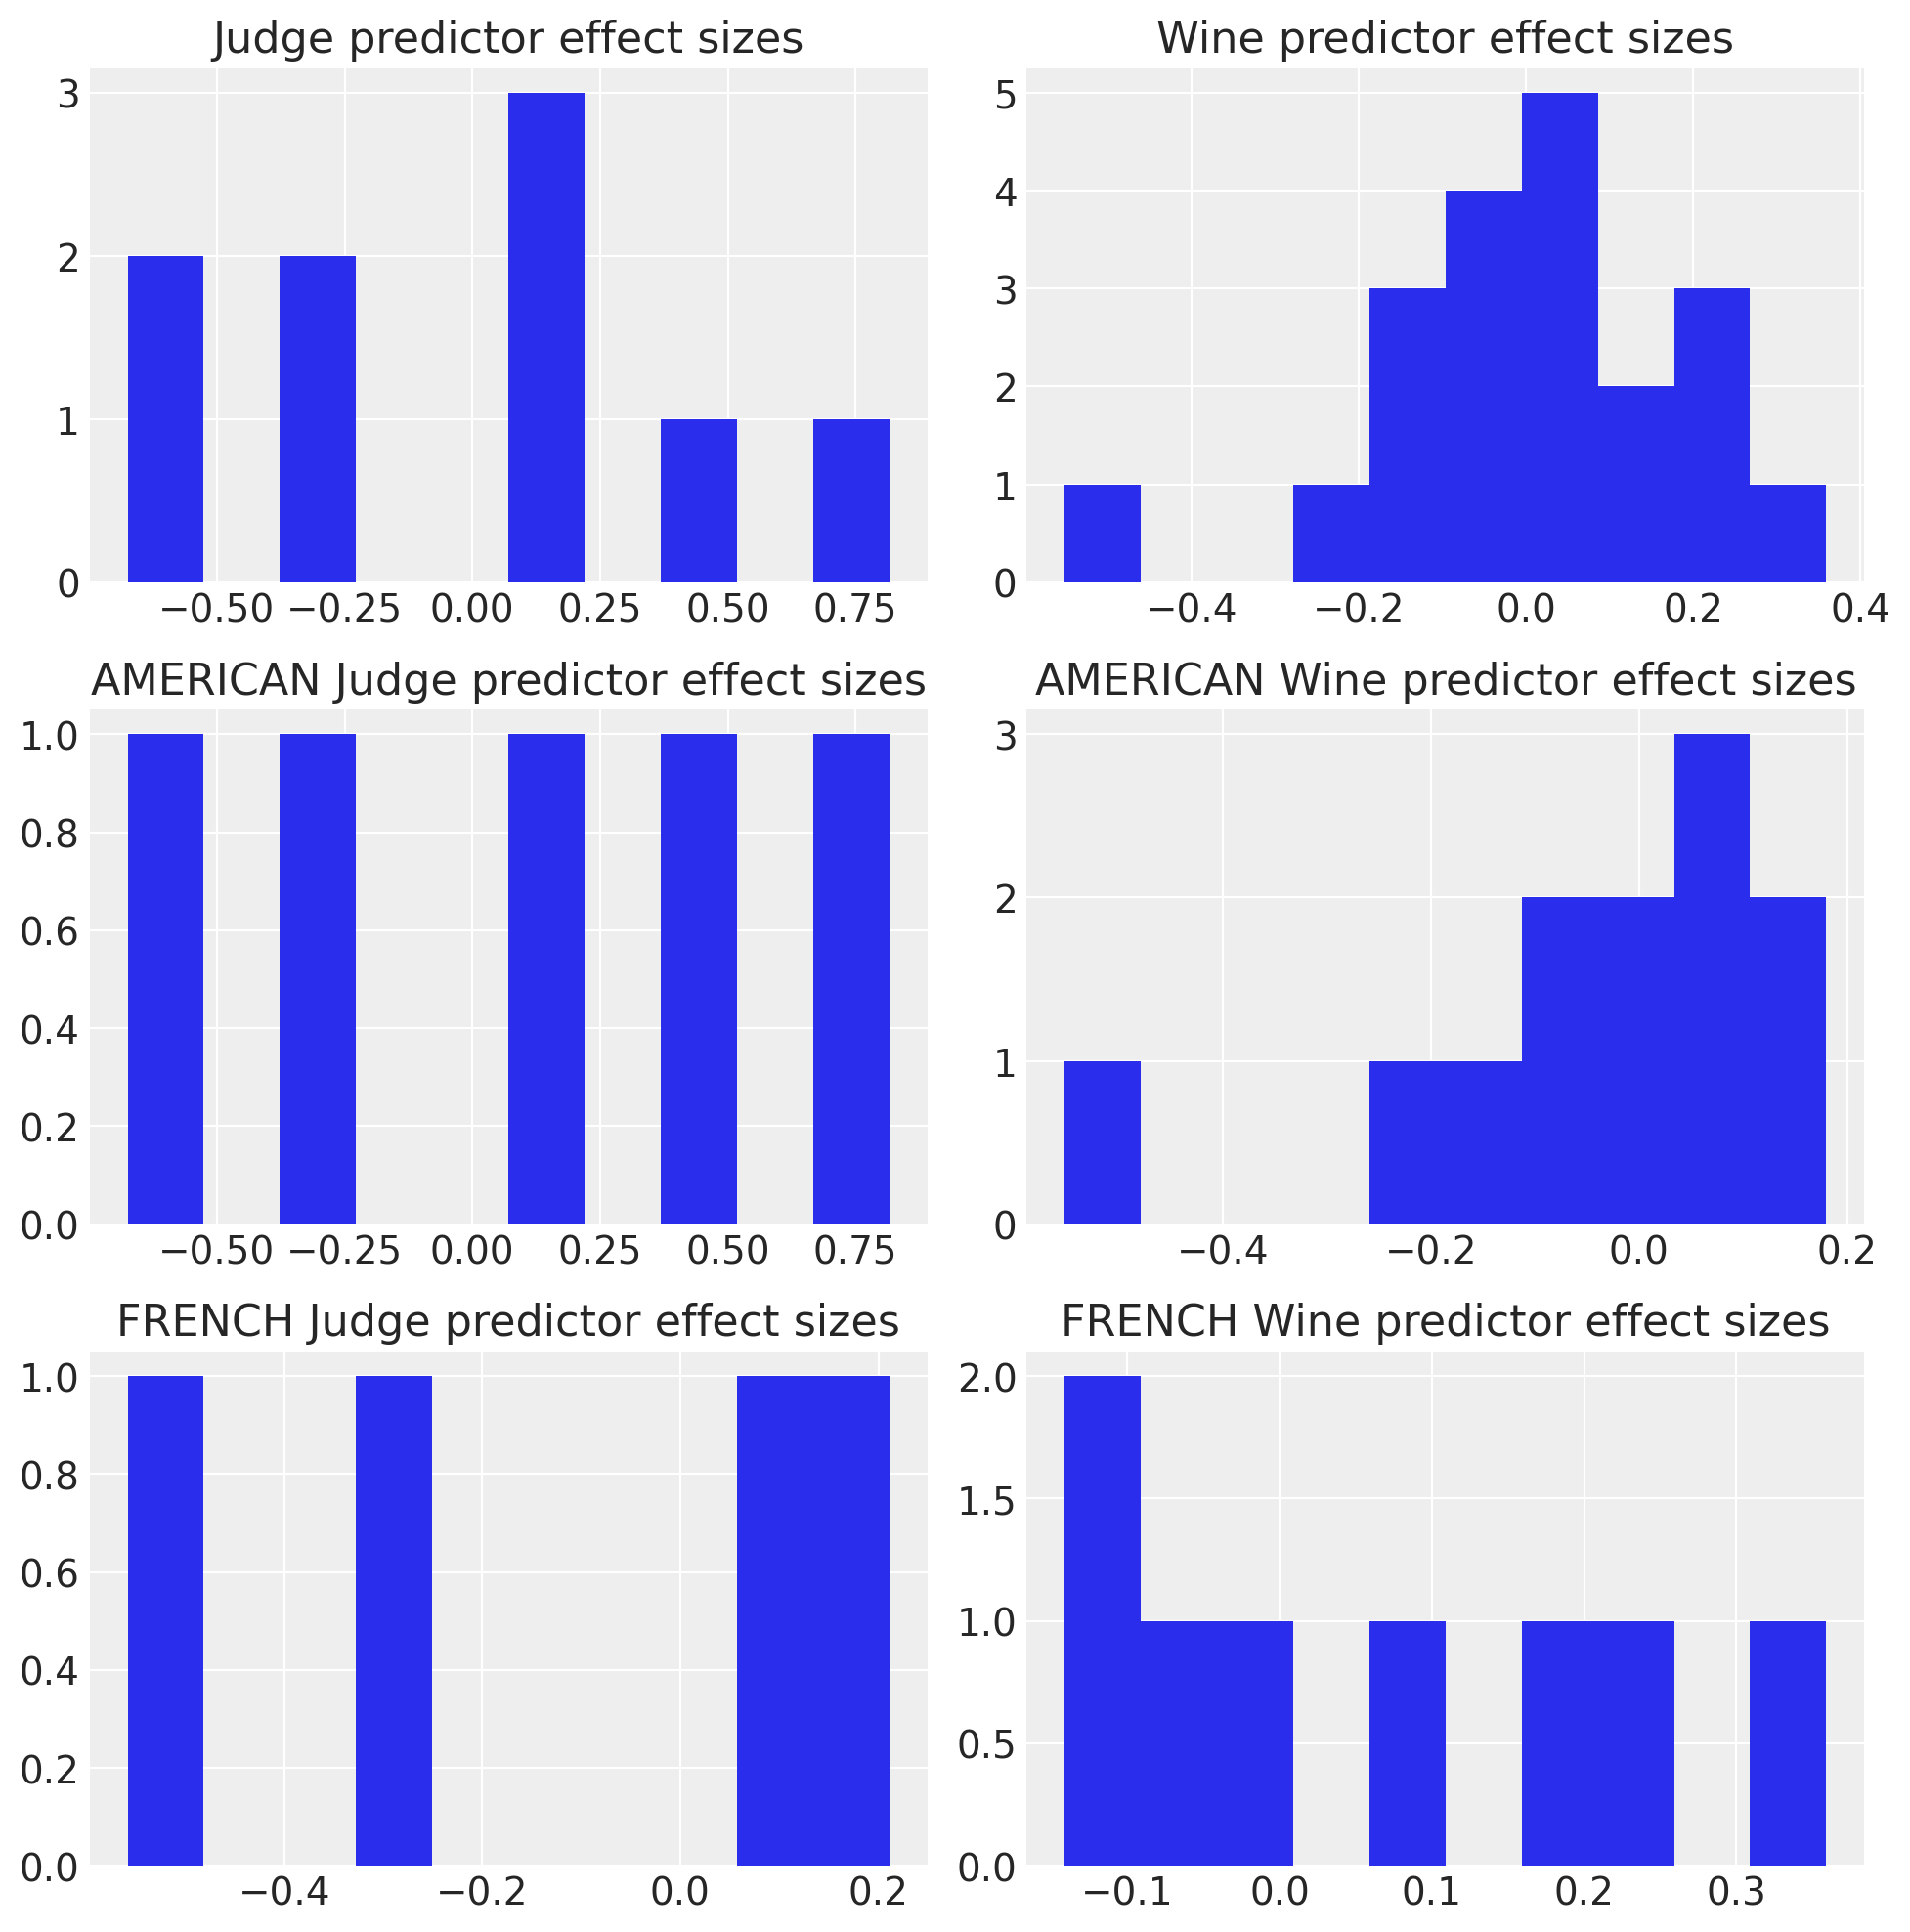

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs[0, 0].hist(alpha_summary["mean"])
axs[0, 0].set_title("Judge predictor effect sizes")

axs[0, 1].set_title("Wine predictor effect sizes")
axs[0, 1].hist(beta_summary["mean"])


axs[1, 0].hist(tempdf[tempdf["judge.amer"] == 1].judge_effect)
axs[1, 0].set_title("AMERICAN Judge predictor effect sizes")

axs[1, 1].set_title("AMERICAN Wine predictor effect sizes")
axs[1, 1].hist(tempdf2[tempdf2["wine.amer"] == 1].wine_effect)


axs[2, 0].hist(tempdf[tempdf["judge.amer"] == 0].judge_effect)
axs[2, 0].set_title("FRENCH Judge predictor effect sizes")

axs[2, 1].set_title("FRENCH Wine predictor effect sizes")
axs[2, 1].hist(tempdf2[tempdf2["wine.amer"] == 0].wine_effect)

plt.tight_layout();

As can be sen here there's a fairly broad dispersion in effect sizes for the judges. Some having hugely positive and some having hugely negative tendencies for their scoring. The wine however appears to be fairly tightly clustered around zero. This indicates the score is more determined by the judges than by the wine. There is however one quite negative outlier. A plausible explanation is that most wines have a similar quality to each other and the score comes down to the preferences of the different judges. However, a truly awful wine commands agreement amongst the judges for the producing a very low score for all of them. Entertainingly, the very bad wine is American.
There's vague tendency for both American wines and judges to have a considerable range of predictive powers in the models. In general the French wines appear to have a slightly positive predictive effect on the score in this model.

### 8H6.

Now consider three features of the wines and judges:

(1) flight: Whether the wine is red or white.

(2) wine.amer: Indicator variable for American wines.

(3) judge.amer: Indicator variable for American judges.

Use indicator or index variables to model the influence of these features on the scores. Omit the
individual judge and wine index variables from Problem 1. Do not include interaction effects yet.
Again justify your priors. What do you conclude about the differences among the wines and judges?
Try to relate the results to the inferences in the previous problem.

#### Answer

Let's suppose the following DAG.

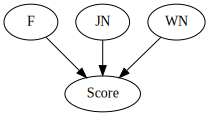

In [54]:
Dag = CausalGraphicalModel(
    nodes=["JN", "WN", "F", "Score"],
    edges=[("JN", "Score"), ("WN", "Score"), ("F", "Score")],
)

# draw return a graphviz `dot` object, which jupyter can render

Dag.draw()

The regression model this time looks something like $\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]} + \gamma_{CIV[i]}$

where $\alpha, \beta, \gamma$ are the effect sizes for JN, WN, and F respectively, each being index variables, because the effect size depends on whether or not you're American.

Putting priors onto this model is challenging. The same information theoretic  argument regarding the noise around $\mu$ from last time holds here. It's hard to imagine that the mean score conditional on these binary random variables could shift that substantially away from the mean. Inspecting the data we can get a rough idea of the effect sizes we'd expect (AGAIN, I think this could be a completely illegitimate way actually form priors). I'm going to use N(0,0.1) as my prior on all of these index variables.

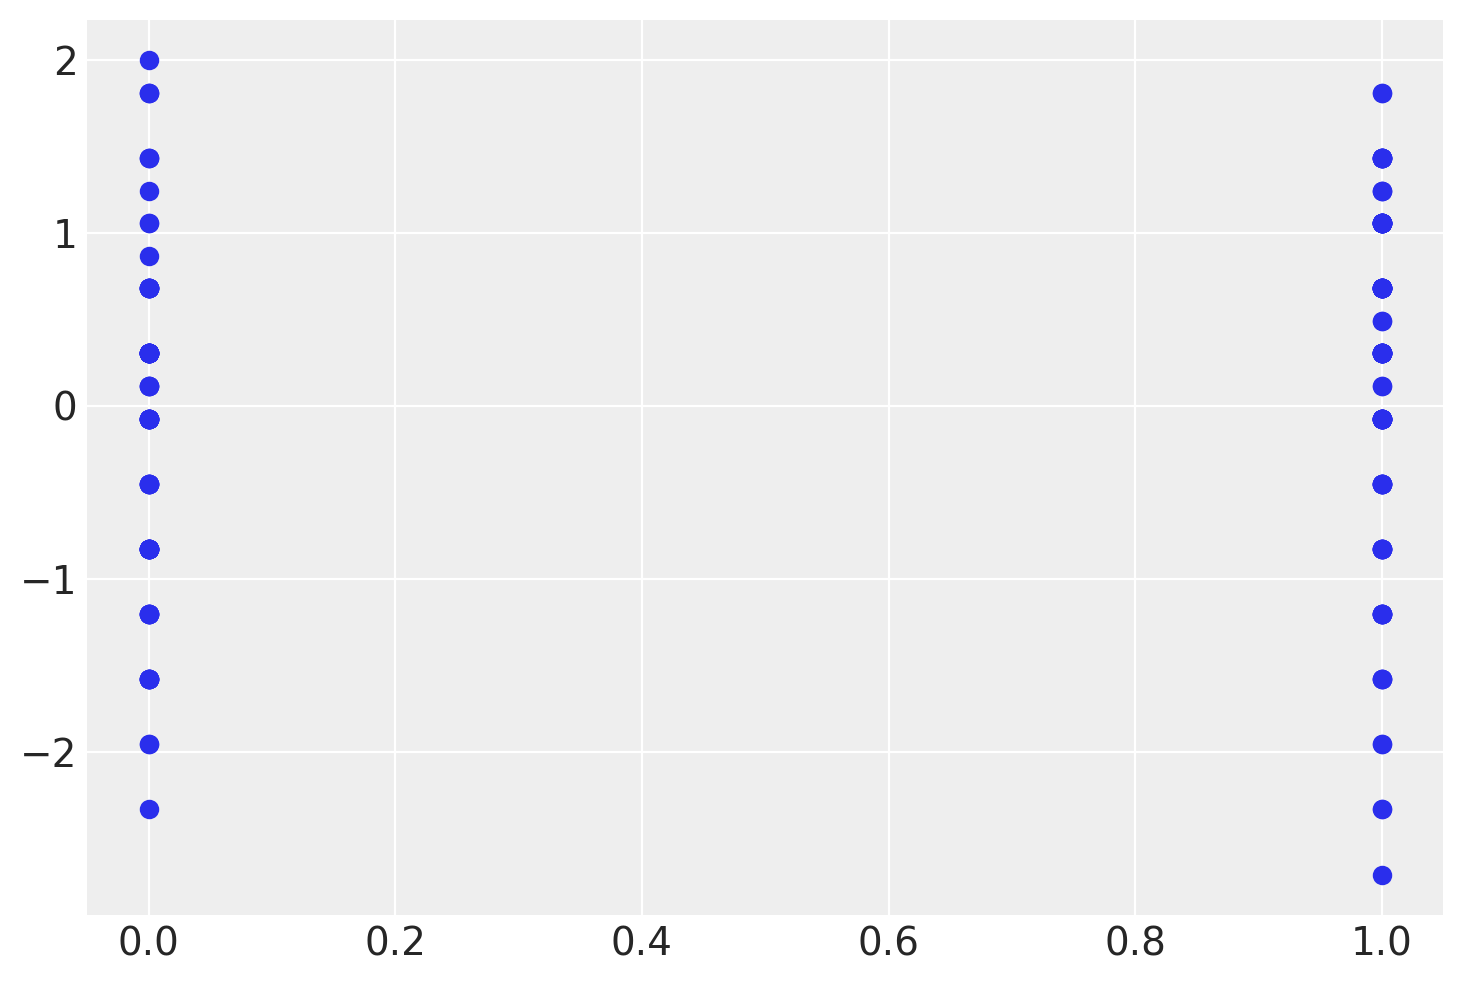

In [55]:
plt.scatter(wine["judge.amer"], wine["s_score"]);

In [56]:
wine.flight = pd.Categorical(wine.flight)
wine["flight_index"] = wine.flight.cat.codes

In [57]:
wine.groupby("judge.amer").s_score.mean(), wine.groupby("wine.amer").s_score.mean(), wine.groupby(
    "flight_index"
).s_score.mean()

(judge.amer
 0   -0.138808
 1    0.111047
 Name: s_score, dtype: float64,
 wine.amer
 0    0.115543
 1   -0.077029
 Name: s_score, dtype: float64,
 flight_index
 0   -0.002091
 1    0.002091
 Name: s_score, dtype: float64)

In [58]:
with pm.Model() as other_wine_score:
    alpha = pm.Normal("alpha", 0, 0.1, shape=(2))
    beta = pm.Normal("beta", 0, 0.1, shape=(2))
    gamma = pm.Normal("gamma", 0, 0.1, shape=(2))
    sigma = pm.Exponential("sigma", 1)
    mu = alpha[wine["judge.amer"]] + beta[wine["wine.amer"]] + gamma[wine.flight_index]
    wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    other_wine_post = pm.sample(draws=1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gamma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [59]:
az.summary(other_wine_post)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.060,0.081,-0.195,0.064,0.001,0.001,4437.0,2797.0,4441.0,3329.0,1.0
alpha[1],0.058,0.079,-0.062,0.189,0.001,0.001,3673.0,3428.0,3664.0,2664.0,1.0
beta[0],0.043,0.080,-0.080,0.175,0.001,0.001,4232.0,3060.0,4232.0,3366.0,1.0
beta[1],-0.044,0.076,-0.155,0.085,0.001,0.001,3915.0,3339.0,3927.0,2919.0,1.0
gamma[0],0.001,0.083,-0.127,0.137,0.001,0.001,3577.0,2495.0,3587.0,3414.0,1.0
gamma[1],0.004,0.081,-0.121,0.135,0.001,0.001,3533.0,2520.0,3532.0,2766.0,1.0
sigma,1.001,0.052,0.919,1.083,0.001,0.001,4268.0,4249.0,4289.0,3243.0,1.0


Many of these predictor variables have 97% compatibility intervals which surround 0 effect size, indicating there isn't a lot of predictive power in knowing these binary variables. This is seen further in that the mean sigma in this model is precisely one, the maximum value that it would take if z scores and these binary random variables were completely independent of one another. To summarize, this model, left as is, is terrible, matching expectations found from our previous model.

### 8H7.

Now consider two-way interactions among the three features. You should end up with three
different interaction terms in your model. These will be easier to build, if you use indicator variables.
Again justify your priors. Explain what each interaction means. Be sure to interpret the model’s
predictions on the outcome scale (mu, the expected score), not on the scale of individual parameters.
You can use link to help with this, or just use your knowledge of the linear model instead. What do
you conclude about the features and the scores? Can you relate the results of your model(s) to the
individual judge and wine inferences from 8H5?

#### Answer

Using the indicator variables for this is challenging. It seems plausible that people would have a bias for or against wine from their own country. I'm going to imagine that French white wines would get bonus points, as they're particularly good, and further more that French judges have a preference for white wines, as white wine is more commonly grown in France. I cannot imagine that these effects are large. They're encoded into the model in the following way:


$\mu_i = \alpha_{CIV[i]} + \beta_{CIV[i]} + \gamma_{CIV[i]} + \phi_{(J,W)} \mathbb{1}_{(JN=WN)}  + \phi{(W,F) }\mathbb{1}_{(JN=0 \cap F=W)} + \phi_{(W,F)} \mathbb{1}_{(W=0 \cap F=W)} $

These indicator functions capture these interaction effects and the $\phi$ terms encode the size of the interactions. These effects are likely to be small, so the following prior - N(0,0.2) - is appropriate.

In [60]:
# create the features for the indicator functions
cond0 = (wine["wine.amer"] == wine["judge.amer"]) + 0  # american wine and american judge
cond1 = (wine["judge.amer"] == 0) & (wine.flight_index == 1)  # french judge and white wine
cond2 = (wine["wine.amer"] == 0) & (wine.flight_index == 1)  # french wine and white wine

In [61]:
# write this interaction model

with pm.Model() as Interacting_wine_score:
    alpha = pm.Normal("alpha", 0, 0.1, shape=(2))
    beta = pm.Normal("beta", 0, 0.1, shape=(2))
    gamma = pm.Normal("gamma", 0, 0.1, shape=(2))
    phi = pm.Normal("phi", 0, 0.2, shape=(3))
    sigma = pm.Exponential("sigma", 1)

    mu = (
        alpha[wine["judge.amer"]]
        + beta[wine["wine.amer"]]
        + gamma[wine.flight_index]
        + phi[0] * cond0
        + phi[1] * cond1
        + phi[2] * cond2
    )
    wine_score = pm.Normal("wine_score", mu=mu, sd=sigma, observed=wine.s_score)
    interacting_wine_post = pm.sample(draws=1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, phi, gamma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [62]:
az.summary(interacting_wine_post)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.045,0.085,-0.188,0.081,0.001,0.001,4966.0,2391.0,4960.0,3222.0,1.0
alpha[1],0.064,0.082,-0.064,0.194,0.001,0.001,5279.0,3354.0,5262.0,3366.0,1.0
beta[0],0.062,0.083,-0.072,0.191,0.001,0.001,4967.0,2809.0,4923.0,3037.0,1.0
beta[1],-0.043,0.082,-0.171,0.089,0.001,0.001,4931.0,2553.0,4951.0,3027.0,1.0
gamma[0],-0.006,0.084,-0.135,0.127,0.001,0.001,4857.0,1701.0,4853.0,3062.0,1.0
gamma[1],0.019,0.086,-0.118,0.153,0.001,0.001,5255.0,2226.0,5256.0,3103.0,1.0
phi[0],-0.016,0.110,-0.183,0.165,0.002,0.002,5213.0,2208.0,5221.0,3513.0,1.0
phi[1],-0.036,0.143,-0.270,0.180,0.002,0.002,5211.0,2331.0,5216.0,3113.0,1.0
phi[2],-0.078,0.145,-0.306,0.152,0.002,0.002,5204.0,3290.0,5208.0,3361.0,1.0
sigma,1.002,0.053,0.922,1.089,0.001,0.001,5249.0,5203.0,5302.0,2789.0,1.0


The model shows that these interaction effects are compatible with zero predictive power. Moreover we can compare this with the models from earlier and see that the interaction model performs far worse than the simpler non-interacting regressions from earlier. This indicates these interaction effects are weak.

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


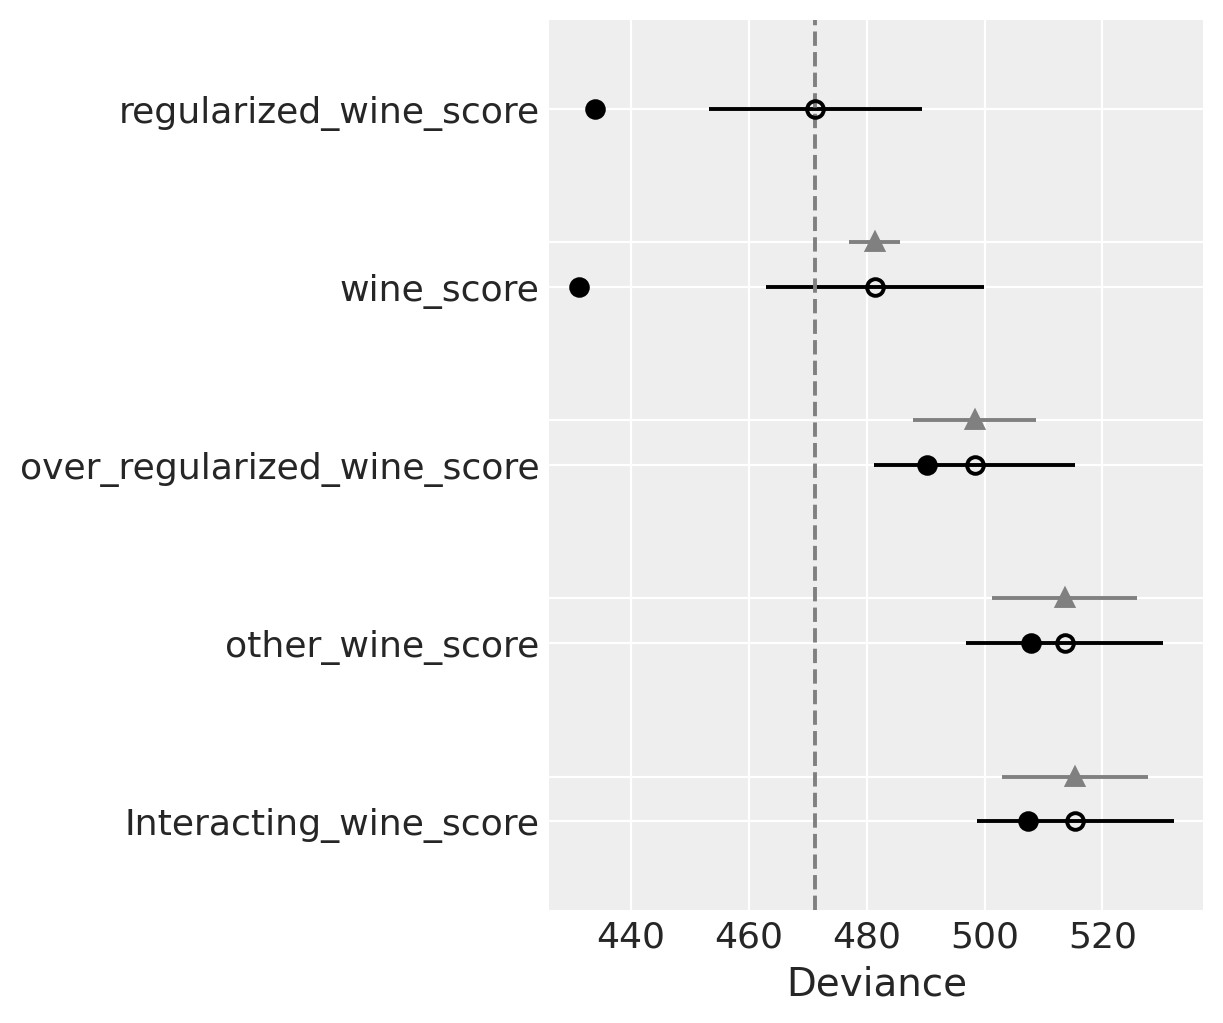

In [63]:
# let's compare all of the models
compare_df = az.compare(
    {
        "wine_score": wine_post,
        "regularized_wine_score": regularized_wine_post,
        "over_regularized_wine_score": over_regularized_wine_post,
        "other_wine_score": other_wine_post,
        "Interacting_wine_score": interacting_wine_post,
    },
    ic="waic",
    scale="deviance",
)
az.plot_compare(compare_df);

In [64]:
%watermark -n -u -v -iv -w

Last updated: Sat Dec 26 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

matplotlib: 3.3.2
numpy     : 1.19.1
pymc3     : 3.9.3
arviz     : 0.9.0
seaborn   : 0.11.0
pandas    : 1.1.3

Watermark: 2.1.0

